In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(font_scale=2)

In [2]:
# !cd tools/ && python setup_opera_distance_metric.py build_ext --inplace

In [3]:
from tools.opera_distance_metric import generate_k_nearest_graph, \
                                        opera_distance_metric_py, \
                                        generate_radius_graph

In [4]:
import networkx as nx

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import Sequential
from torch.distributions import Bernoulli

In [5]:
from graph_rnn import bfs_seq, encode_adj, decode_adj, encode_adj_flexible, decode_adj_flexible

In [6]:
device = torch.device('cpu')

In [7]:
df = pd.read_pickle('./data/showers.pkl')

In [8]:
def bfs_handmade(G, start):
    visited, queue = set(), [start]
    while queue:
        vertex = queue.pop(0)
        if vertex not in visited:
            visited.add(vertex)
            edges = sorted(G.out_edges(vertex, data=True), key=lambda x: x[2]['weight'])
            queue.extend(set([x[1] for x in edges]) - visited)
    return np.array(list(visited))[np.argsort(np.array(list(G.nodes())))]


def encode_adj(adj, max_prev_node=10, is_full = False):
    '''
    :param adj: n*n, rows means time step, while columns are input dimension
    :param max_degree: we want to keep row number, but truncate column numbers
    :return:
    '''
    if is_full:
        max_prev_node = adj.shape[0] - 1
    
    # successors only
    adj = adj
    
    # pick up lower tri
    adj = np.tril(adj, k=-1)
    n = adj.shape[0]
    adj = adj[1:n, 0:n-1]

    # use max_prev_node to truncate
    # note: now adj is a (n-1) * (n-1) matrix
    adj_output = np.zeros((adj.shape[0], max_prev_node))
    for i in range(adj.shape[0]):
        input_start = max(0, i - max_prev_node + 1)
        input_end = i + 1
        output_start = max_prev_node + input_start - input_end
        output_end = max_prev_node
        adj_output[i, output_start:output_end] = adj[i, input_start:input_end]
        adj_output[i,:] = adj_output[i,:][::-1] # reverse order

    return adj_output

In [93]:
%%time
for i, shower in df.iterrows():
    X = np.vstack([
        np.arange(len(shower.SX)),
        shower.SX,
        shower.SY,  
        shower.SZ, 
        shower.TX,
        shower.TY,
        shower.ele_P]
    ).T
    edges_from, edges_to, distances = generate_k_nearest_graph(X, k=3, symmetric=False)
    G = nx.Graph()
    edges = []
    for i in range(len(distances)):
        edges.append((edges_from[i], edges_to[i], {'weight': distances[i]}))
    G.add_edges_from(edges)
    G = nx.DiGraph(G)

    adj = np.asarray(nx.to_numpy_matrix(G))

    start_idx = 0
    x_idx = np.array(bfs_handmade(G, start_idx))
    adj = adj[np.ix_(x_idx, x_idx)]

    # actual data
    adj_output = encode_adj(adj, max_prev_node=10)
    X = X[x_idx, 1:]
    X = X / np.array([1e3, 1e3, 1e3, 1, 1, 1])
    distances = np.log(distances)
    break

CPU times: user 52 ms, sys: 8 ms, total: 60 ms
Wall time: 55.4 ms


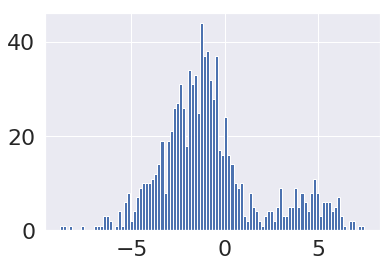

In [94]:
plt.hist(distances, bins=100);

In [95]:
graph_state_size = 64

In [96]:
h = torch.nn.Sequential(nn.Linear(6, 32), nn.ReLU(), 
                        nn.Linear(32, 32), nn.ReLU(), 
                        nn.Linear(32, graph_state_size))

In [106]:
sigmoid = nn.Sigmoid()
loss_bce = nn.BCELoss()
loss_mse = torch.nn.MSELoss()

In [98]:
class GraphRNN(nn.Module):
    def __init__(self, m):
        super().__init__()
        self.m = m
        self.node_rnn = nn.GRUC(graph_state_size + self.m, graph_state_size)
        
        self.edge_nn = nn.Sequential(
            nn.Linear(graph_state_size, 32), nn.ReLU(),
            nn.Linear(32, self.m)
        )
        self.feature_generator = nn.Linear(graph_state_size, 5)
        
    def forward(self, graph_state, num_nodes):
        nodes = [self.feature_generator(graph_state)]
        edges = [torch.zeros(1, self.m).to(graph_state.device)]
        for i in range(num_nodes):
            graph_state = self.node_rnn(torch.cat([graph_state, edges[i]], dim=1), graph_state)
            edge_state = self.edge_nn(graph_state)
            nodes.append(self.feature_generator(graph_state))
            edges.append(edge_state)
        return nodes, edges
mod = GraphRNN(10).to(device)

In [99]:
from itertools import chain


learning_rate = 1e-2
optimizer = torch.optim.Adam(list(mod.parameters()) + list(h.parameters()), lr=learning_rate)

In [100]:
from tqdm import tqdm

In [101]:
adj_output[adj_output!=0] = 1.

In [102]:
adj_output.shape

(317, 10)

In [103]:
for i in tqdm(range(1000)):
    optimizer.zero_grad()
    
    h_0 = h(torch.tensor(X[0:1, ], dtype=torch.float32))
    nodes, edges = mod(graph_state=h_0.to(device), num_nodes=316)
    # l2_loss = torch.sum((torch.cat(nodes) - torch.tensor(X[1:, :-1], dtype=torch.float32)).pow(2), dim=1).mean().sqrt()
    ll_bce = loss_bce(sigmoid(torch.cat(edges)), torch.tensor(adj_output, dtype=torch.float32))
    # ll = l2_loss + ll_bce * 100
    
    ll_bce.backward()
    
    optimizer.step()
    
    print(ll_bce.item())



  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 1/1000 [00:00<03:58,  4.18it/s]

0.6787971258163452




  0%|          | 2/1000 [00:00<03:55,  4.24it/s]

0.6484197974205017




  0%|          | 3/1000 [00:00<03:48,  4.36it/s]

0.5953213572502136




  0%|          | 4/1000 [00:00<03:42,  4.49it/s]

0.5545405745506287




  0%|          | 5/1000 [00:01<03:36,  4.60it/s]

0.5348184108734131




  1%|          | 6/1000 [00:01<03:34,  4.63it/s]

0.5338123440742493




  1%|          | 7/1000 [00:01<03:30,  4.72it/s]

0.5351037979125977




  1%|          | 8/1000 [00:01<03:35,  4.61it/s]

0.53251713514328




  1%|          | 9/1000 [00:01<03:36,  4.57it/s]

0.5300809144973755




  1%|          | 10/1000 [00:02<03:32,  4.65it/s]

  1%|          | 11/1000 [00:02<03:27,  4.76it/s]

0.5291303992271423
0.5283342003822327




  1%|          | 12/1000 [00:02<03:28,  4.74it/s]

0.5265393853187561




  1%|▏         | 13/1000 [00:02<03:30,  4.70it/s]

0.523993194103241




  1%|▏         | 14/1000 [00:03<03:31,  4.66it/s]

0.5221441984176636




  2%|▏         | 15/1000 [00:03<03:38,  4.52it/s]

0.5207498073577881




  2%|▏         | 16/1000 [00:03<03:34,  4.58it/s]

0.5198279619216919




  2%|▏         | 17/1000 [00:03<03:32,  4.63it/s]

0.5206214785575867




  2%|▏         | 18/1000 [00:03<03:29,  4.68it/s]

0.5192837715148926




  2%|▏         | 19/1000 [00:04<03:26,  4.74it/s]

0.5195860266685486




  2%|▏         | 20/1000 [00:04<03:26,  4.74it/s]

  2%|▏         | 21/1000 [00:04<03:21,  4.86it/s]

0.5186998844146729
0.5183035135269165




  2%|▏         | 22/1000 [00:04<03:18,  4.92it/s]

0.5178831219673157




  2%|▏         | 23/1000 [00:04<03:20,  4.86it/s]

  2%|▏         | 24/1000 [00:05<03:17,  4.93it/s]

0.5171923041343689
0.517236590385437




  2%|▎         | 25/1000 [00:05<03:18,  4.92it/s]

0.5178378224372864




  3%|▎         | 26/1000 [00:05<03:18,  4.90it/s]

  3%|▎         | 27/1000 [00:05<03:16,  4.96it/s]

0.5182216167449951
0.5193934440612793




  3%|▎         | 28/1000 [00:05<03:24,  4.76it/s]

  3%|▎         | 29/1000 [00:06<03:20,  4.85it/s]

0.5195945501327515
0.5191783905029297




  3%|▎         | 30/1000 [00:06<03:17,  4.92it/s]

  3%|▎         | 31/1000 [00:06<03:15,  4.96it/s]

0.5186548829078674
0.5179077982902527




  3%|▎         | 32/1000 [00:06<03:24,  4.73it/s]

0.516353964805603




  3%|▎         | 33/1000 [00:06<03:22,  4.77it/s]

0.5200669765472412




  3%|▎         | 34/1000 [00:07<03:23,  4.75it/s]

0.517758309841156




  4%|▎         | 35/1000 [00:07<03:20,  4.80it/s]

0.5184787511825562




  4%|▎         | 36/1000 [00:07<03:24,  4.70it/s]

0.5180193781852722




  4%|▎         | 37/1000 [00:07<03:25,  4.68it/s]

0.5187734365463257




  4%|▍         | 38/1000 [00:08<03:22,  4.75it/s]

0.5175655484199524




  4%|▍         | 39/1000 [00:08<03:21,  4.76it/s]

0.5173944234848022




  4%|▍         | 40/1000 [00:08<03:23,  4.71it/s]

0.5172706842422485




  4%|▍         | 41/1000 [00:08<03:26,  4.65it/s]

0.5172858834266663




  4%|▍         | 42/1000 [00:08<03:23,  4.70it/s]

0.5174999237060547




  4%|▍         | 43/1000 [00:09<03:27,  4.62it/s]

0.5166929960250854




  4%|▍         | 44/1000 [00:09<03:27,  4.60it/s]

0.5166240334510803




  4%|▍         | 45/1000 [00:09<03:36,  4.41it/s]

0.5165756940841675




  5%|▍         | 46/1000 [00:09<03:36,  4.41it/s]

0.5168070197105408




  5%|▍         | 47/1000 [00:10<03:33,  4.45it/s]

0.5164380073547363




  5%|▍         | 48/1000 [00:10<03:31,  4.50it/s]

0.5161770582199097




  5%|▍         | 49/1000 [00:10<03:39,  4.33it/s]

0.5159012079238892




  5%|▌         | 50/1000 [00:10<03:35,  4.41it/s]

0.5157834887504578




  5%|▌         | 51/1000 [00:10<03:34,  4.41it/s]

0.5158743858337402




  5%|▌         | 52/1000 [00:11<03:34,  4.42it/s]

0.5154615640640259




  5%|▌         | 53/1000 [00:11<03:31,  4.47it/s]

0.5152614116668701




  5%|▌         | 54/1000 [00:11<03:30,  4.49it/s]

0.5150337815284729




  6%|▌         | 55/1000 [00:11<03:30,  4.50it/s]

0.5150907635688782




  6%|▌         | 56/1000 [00:12<03:32,  4.45it/s]

0.5147900581359863




  6%|▌         | 57/1000 [00:12<03:29,  4.51it/s]

0.5147773623466492




  6%|▌         | 58/1000 [00:12<03:28,  4.51it/s]

0.5145591497421265




  6%|▌         | 59/1000 [00:12<03:28,  4.52it/s]

0.5146058201789856




  6%|▌         | 60/1000 [00:12<03:29,  4.49it/s]

0.5145392417907715




  6%|▌         | 61/1000 [00:13<03:35,  4.36it/s]

0.5142730474472046




  6%|▌         | 62/1000 [00:13<03:32,  4.41it/s]



0.5149379968643188
0.5144608020782471


  6%|▋         | 63/1000 [00:13<03:24,  4.58it/s]

  6%|▋         | 64/1000 [00:13<03:16,  4.76it/s]

0.5150545239448547




  6%|▋         | 65/1000 [00:13<03:18,  4.71it/s]

0.5150830745697021




  7%|▋         | 66/1000 [00:14<03:18,  4.70it/s]

0.514289379119873




  7%|▋         | 67/1000 [00:14<03:17,  4.72it/s]

0.5136176943778992




  7%|▋         | 68/1000 [00:14<03:18,  4.68it/s]

0.5161716938018799




  7%|▋         | 69/1000 [00:14<03:19,  4.66it/s]

0.5149285793304443




  7%|▋         | 70/1000 [00:15<03:19,  4.66it/s]

0.5154188871383667




  7%|▋         | 71/1000 [00:15<03:18,  4.69it/s]

0.5162811279296875




  7%|▋         | 72/1000 [00:15<03:19,  4.65it/s]

  7%|▋         | 73/1000 [00:15<03:13,  4.78it/s]

0.5159376859664917
0.5159770846366882




  7%|▋         | 74/1000 [00:15<03:11,  4.84it/s]



0.5153347849845886
0.5153080821037292


  8%|▊         | 75/1000 [00:16<03:09,  4.89it/s]

  8%|▊         | 76/1000 [00:16<03:08,  4.91it/s]

0.5145642757415771
0.5141497850418091




  8%|▊         | 77/1000 [00:16<03:07,  4.94it/s]

  8%|▊         | 78/1000 [00:16<03:05,  4.96it/s]

0.520491898059845




  8%|▊         | 79/1000 [00:16<03:03,  5.01it/s]

0.5154978632926941




  8%|▊         | 80/1000 [00:17<03:06,  4.95it/s]

  8%|▊         | 81/1000 [00:17<03:04,  4.98it/s]

0.5166579484939575
0.5161616802215576




  8%|▊         | 82/1000 [00:17<03:04,  4.97it/s]

0.5168035626411438




  8%|▊         | 83/1000 [00:17<03:06,  4.91it/s]

  8%|▊         | 84/1000 [00:17<03:04,  4.95it/s]

0.5162793397903442
0.5165737271308899




  8%|▊         | 85/1000 [00:18<03:17,  4.63it/s]

0.5164818167686462




  9%|▊         | 86/1000 [00:18<03:16,  4.66it/s]

0.51560378074646




  9%|▊         | 87/1000 [00:18<03:15,  4.68it/s]

0.5161409378051758




  9%|▉         | 88/1000 [00:18<03:15,  4.66it/s]

0.5153383016586304




  9%|▉         | 89/1000 [00:19<03:15,  4.65it/s]

0.5153869390487671




  9%|▉         | 90/1000 [00:19<03:15,  4.66it/s]

  9%|▉         | 91/1000 [00:19<03:09,  4.80it/s]

0.515023410320282
0.5152410268783569




  9%|▉         | 92/1000 [00:19<03:08,  4.81it/s]

0.5145457983016968




  9%|▉         | 93/1000 [00:19<03:07,  4.84it/s]

0.5146828293800354




  9%|▉         | 94/1000 [00:20<03:06,  4.87it/s]

0.5145120620727539




 10%|▉         | 95/1000 [00:20<03:07,  4.84it/s]

0.5139914751052856




 10%|▉         | 96/1000 [00:20<03:12,  4.70it/s]

0.5138471722602844




 10%|▉         | 97/1000 [00:20<03:09,  4.76it/s]

0.5133926272392273




 10%|▉         | 98/1000 [00:20<03:09,  4.75it/s]

0.5135003328323364




 10%|▉         | 99/1000 [00:21<03:11,  4.71it/s]

 10%|█         | 100/1000 [00:21<03:06,  4.83it/s]

0.5130811333656311
0.5131392478942871




 10%|█         | 101/1000 [00:21<03:08,  4.77it/s]

0.5126160383224487




 10%|█         | 102/1000 [00:21<03:15,  4.60it/s]

0.5125004053115845




 10%|█         | 103/1000 [00:21<03:20,  4.48it/s]

0.5122637152671814




 10%|█         | 104/1000 [00:22<03:21,  4.46it/s]

0.5122352838516235




 10%|█         | 105/1000 [00:22<03:20,  4.46it/s]

0.5121259689331055




 11%|█         | 106/1000 [00:22<03:18,  4.50it/s]

0.5117708444595337




 11%|█         | 107/1000 [00:22<03:17,  4.51it/s]

0.5117602348327637




 11%|█         | 108/1000 [00:23<03:16,  4.53it/s]

0.5116961598396301




 11%|█         | 109/1000 [00:23<03:15,  4.55it/s]

0.5113697648048401




 11%|█         | 110/1000 [00:23<03:15,  4.55it/s]

0.5112221240997314




 11%|█         | 111/1000 [00:23<03:14,  4.57it/s]

0.5110745429992676




 11%|█         | 112/1000 [00:23<03:13,  4.58it/s]

0.5108687281608582




 11%|█▏        | 113/1000 [00:24<03:15,  4.53it/s]

0.5105708241462708




 11%|█▏        | 114/1000 [00:24<03:17,  4.48it/s]

0.5104100704193115




 12%|█▏        | 115/1000 [00:24<03:14,  4.55it/s]

0.5102199912071228




 12%|█▏        | 116/1000 [00:24<03:10,  4.65it/s]



0.5100270509719849
0.5103310942649841


 12%|█▏        | 117/1000 [00:25<03:06,  4.74it/s]

 12%|█▏        | 118/1000 [00:25<03:04,  4.77it/s]

0.5130928158760071




 12%|█▏        | 119/1000 [00:25<03:07,  4.71it/s]

0.5150278210639954




 12%|█▏        | 120/1000 [00:25<03:05,  4.73it/s]

0.5165242552757263




 12%|█▏        | 121/1000 [00:25<03:07,  4.68it/s]

0.5166220664978027




 12%|█▏        | 122/1000 [00:26<03:08,  4.66it/s]

0.520332396030426




 12%|█▏        | 123/1000 [00:26<03:10,  4.59it/s]

0.5183729529380798




 12%|█▏        | 124/1000 [00:26<03:07,  4.67it/s]

0.5184868574142456




 12%|█▎        | 125/1000 [00:26<03:09,  4.61it/s]

0.5183122754096985




 13%|█▎        | 126/1000 [00:26<03:05,  4.70it/s]

0.5175151824951172




 13%|█▎        | 127/1000 [00:27<03:07,  4.65it/s]

0.5160436630249023
0.5151921510696411




 13%|█▎        | 128/1000 [00:27<03:03,  4.75it/s]

 13%|█▎        | 129/1000 [00:27<03:07,  4.64it/s]

0.5171485543251038




 13%|█▎        | 130/1000 [00:27<03:07,  4.63it/s]

0.5158264636993408




 13%|█▎        | 131/1000 [00:28<03:09,  4.59it/s]

0.5153574347496033




 13%|█▎        | 132/1000 [00:28<03:09,  4.59it/s]

0.5161377191543579




 13%|█▎        | 133/1000 [00:28<03:06,  4.64it/s]

0.5155314803123474
0.5153093338012695




 13%|█▎        | 134/1000 [00:28<03:02,  4.74it/s]

 14%|█▎        | 135/1000 [00:28<03:01,  4.76it/s]

0.5153009295463562




 14%|█▎        | 136/1000 [00:29<03:04,  4.69it/s]

0.5147847533226013




 14%|█▎        | 137/1000 [00:29<03:10,  4.53it/s]

0.5147449374198914




 14%|█▍        | 138/1000 [00:29<03:09,  4.54it/s]

0.5146516561508179




 14%|█▍        | 139/1000 [00:29<03:09,  4.54it/s]

0.5143583416938782




 14%|█▍        | 140/1000 [00:29<03:07,  4.59it/s]

0.513929009437561




 14%|█▍        | 141/1000 [00:30<03:07,  4.58it/s]

0.5140230059623718




 14%|█▍        | 142/1000 [00:30<03:03,  4.67it/s]

0.5141291618347168




 14%|█▍        | 143/1000 [00:30<03:00,  4.75it/s]

0.5137674808502197




 14%|█▍        | 144/1000 [00:30<02:58,  4.81it/s]

0.5136837959289551




 14%|█▍        | 145/1000 [00:31<02:56,  4.85it/s]

 15%|█▍        | 146/1000 [00:31<02:52,  4.94it/s]

0.5136449933052063
0.5134901404380798




 15%|█▍        | 147/1000 [00:31<02:51,  4.98it/s]

0.5134314894676208




 15%|█▍        | 148/1000 [00:31<03:02,  4.66it/s]

0.5132359266281128




 15%|█▍        | 149/1000 [00:31<03:11,  4.45it/s]

0.5129725933074951




 15%|█▌        | 150/1000 [00:32<03:22,  4.19it/s]

0.5129269361495972




 15%|█▌        | 151/1000 [00:32<03:27,  4.09it/s]

0.5129035711288452




 15%|█▌        | 152/1000 [00:32<03:27,  4.09it/s]

0.5127660632133484




 15%|█▌        | 153/1000 [00:32<03:24,  4.13it/s]

0.5125887989997864




 15%|█▌        | 154/1000 [00:33<03:28,  4.06it/s]

0.512556791305542




 16%|█▌        | 155/1000 [00:33<03:25,  4.11it/s]

0.5125558972358704




 16%|█▌        | 156/1000 [00:33<03:21,  4.18it/s]

0.5123983025550842




 16%|█▌        | 157/1000 [00:33<03:22,  4.17it/s]

0.5122603178024292




 16%|█▌        | 158/1000 [00:34<03:13,  4.35it/s]

0.5123599171638489




 16%|█▌        | 159/1000 [00:34<03:07,  4.48it/s]

0.5120970606803894




 16%|█▌        | 160/1000 [00:34<03:03,  4.59it/s]

0.5119439959526062




 16%|█▌        | 161/1000 [00:34<03:00,  4.64it/s]

0.5118546485900879




 16%|█▌        | 162/1000 [00:34<02:57,  4.72it/s]

0.5116361379623413




 16%|█▋        | 163/1000 [00:35<03:00,  4.63it/s]

0.5115342736244202




 16%|█▋        | 164/1000 [00:35<03:01,  4.60it/s]

0.5118212699890137




 16%|█▋        | 165/1000 [00:35<03:00,  4.63it/s]

0.511191189289093




 17%|█▋        | 166/1000 [00:35<03:01,  4.60it/s]

0.5110536217689514




 17%|█▋        | 167/1000 [00:36<03:00,  4.62it/s]

0.5112453103065491




 17%|█▋        | 168/1000 [00:36<03:01,  4.59it/s]

0.5121088624000549




 17%|█▋        | 169/1000 [00:36<03:01,  4.58it/s]

0.5120466947555542




 17%|█▋        | 170/1000 [00:36<03:00,  4.61it/s]

0.5112850069999695




 17%|█▋        | 171/1000 [00:36<03:02,  4.53it/s]

0.5131965279579163




 17%|█▋        | 172/1000 [00:37<03:02,  4.53it/s]

0.5119922161102295




 17%|█▋        | 173/1000 [00:37<03:01,  4.57it/s]

0.5123651027679443




 17%|█▋        | 174/1000 [00:37<03:04,  4.47it/s]

0.5107867121696472




 18%|█▊        | 175/1000 [00:37<03:11,  4.31it/s]

0.5121378302574158




 18%|█▊        | 176/1000 [00:38<03:10,  4.34it/s]

0.5104890465736389




 18%|█▊        | 177/1000 [00:38<03:10,  4.32it/s]

0.51102614402771




 18%|█▊        | 178/1000 [00:38<03:08,  4.37it/s]

0.5106096267700195
0.5109238624572754




 18%|█▊        | 179/1000 [00:38<03:00,  4.54it/s]

 18%|█▊        | 180/1000 [00:38<03:05,  4.42it/s]

0.5101661682128906




 18%|█▊        | 181/1000 [00:39<03:10,  4.29it/s]

0.5104048252105713




 18%|█▊        | 182/1000 [00:39<03:05,  4.41it/s]

0.5102720260620117




 18%|█▊        | 183/1000 [00:39<02:59,  4.55it/s]

0.5097958445549011
0.510158121585846




 18%|█▊        | 184/1000 [00:39<02:54,  4.67it/s]

 18%|█▊        | 185/1000 [00:40<02:58,  4.57it/s]

0.5095058679580688




 19%|█▊        | 186/1000 [00:40<02:55,  4.63it/s]

0.5096009373664856




 19%|█▊        | 187/1000 [00:40<02:59,  4.54it/s]

0.5091671943664551




 19%|█▉        | 188/1000 [00:40<02:55,  4.64it/s]

0.5094267725944519




 19%|█▉        | 189/1000 [00:40<02:52,  4.71it/s]

 19%|█▉        | 190/1000 [00:41<02:47,  4.83it/s]

0.508864164352417
0.5089582800865173




 19%|█▉        | 191/1000 [00:41<02:50,  4.73it/s]

0.5095140337944031




 19%|█▉        | 192/1000 [00:41<02:48,  4.79it/s]

0.5088739991188049




 19%|█▉        | 193/1000 [00:41<02:49,  4.76it/s]

 19%|█▉        | 194/1000 [00:41<02:46,  4.83it/s]

0.5086594820022583
0.5089961886405945




 20%|█▉        | 195/1000 [00:42<02:50,  4.71it/s]

0.5083418488502502




 20%|█▉        | 196/1000 [00:42<02:49,  4.75it/s]

0.5092371702194214




 20%|█▉        | 197/1000 [00:42<02:52,  4.67it/s]

0.5089685320854187




 20%|█▉        | 198/1000 [00:42<02:52,  4.65it/s]

0.5088890194892883




 20%|█▉        | 199/1000 [00:43<02:57,  4.52it/s]

0.5083643198013306




 20%|██        | 200/1000 [00:43<02:56,  4.53it/s]

0.5077109932899475




 20%|██        | 201/1000 [00:43<02:52,  4.63it/s]

0.5074968338012695




 20%|██        | 202/1000 [00:43<02:53,  4.60it/s]

0.5076911449432373




 20%|██        | 203/1000 [00:43<02:51,  4.65it/s]

0.5087942481040955




 20%|██        | 204/1000 [00:44<02:50,  4.66it/s]

0.5071622133255005




 20%|██        | 205/1000 [00:44<02:51,  4.63it/s]

0.5093538761138916




 21%|██        | 206/1000 [00:44<02:54,  4.55it/s]

0.5087548494338989




 21%|██        | 207/1000 [00:44<02:55,  4.51it/s]

0.5069493651390076




 21%|██        | 208/1000 [00:45<03:00,  4.38it/s]

0.5101794600486755




 21%|██        | 209/1000 [00:45<03:00,  4.38it/s]

0.50739586353302




 21%|██        | 210/1000 [00:45<02:59,  4.39it/s]

0.5146244764328003




 21%|██        | 211/1000 [00:45<02:59,  4.40it/s]

0.5095649361610413




 21%|██        | 212/1000 [00:45<02:59,  4.40it/s]

0.5110233426094055




 21%|██▏       | 213/1000 [00:46<02:58,  4.40it/s]

0.511015772819519




 21%|██▏       | 214/1000 [00:46<02:54,  4.52it/s]

0.5127768516540527




 22%|██▏       | 215/1000 [00:46<02:51,  4.59it/s]

0.509850025177002




 22%|██▏       | 216/1000 [00:46<02:51,  4.57it/s]

0.5128623843193054




 22%|██▏       | 217/1000 [00:46<02:48,  4.64it/s]

0.512451171875




 22%|██▏       | 218/1000 [00:47<02:49,  4.60it/s]

0.5119324922561646




 22%|██▏       | 219/1000 [00:47<02:48,  4.64it/s]

0.5109093189239502




 22%|██▏       | 220/1000 [00:47<02:51,  4.55it/s]

0.5093794465065002




 22%|██▏       | 221/1000 [00:47<02:52,  4.51it/s]

0.5092532634735107




 22%|██▏       | 222/1000 [00:48<02:54,  4.47it/s]

0.5086571574211121




 22%|██▏       | 223/1000 [00:48<02:54,  4.44it/s]

0.5080697536468506




 22%|██▏       | 224/1000 [00:48<02:55,  4.43it/s]

0.5081210136413574




 22%|██▎       | 225/1000 [00:48<02:54,  4.44it/s]

0.5080819129943848




 23%|██▎       | 226/1000 [00:49<02:54,  4.43it/s]

0.5077386498451233




 23%|██▎       | 227/1000 [00:49<02:56,  4.37it/s]

0.5070021748542786




 23%|██▎       | 228/1000 [00:49<03:02,  4.24it/s]

0.5071509480476379




 23%|██▎       | 229/1000 [00:49<02:58,  4.32it/s]

0.5071728825569153




 23%|██▎       | 230/1000 [00:49<02:56,  4.37it/s]

0.5066435933113098




 23%|██▎       | 231/1000 [00:50<02:54,  4.40it/s]

0.5064926743507385




 23%|██▎       | 232/1000 [00:50<02:58,  4.30it/s]

0.5064097046852112




 23%|██▎       | 233/1000 [00:50<02:52,  4.43it/s]

0.5060151815414429




 23%|██▎       | 234/1000 [00:50<02:51,  4.46it/s]

0.505878210067749




 24%|██▎       | 235/1000 [00:51<02:48,  4.53it/s]

0.5057756304740906




 24%|██▎       | 236/1000 [00:51<02:46,  4.60it/s]

0.5055029988288879




 24%|██▎       | 237/1000 [00:51<02:43,  4.67it/s]

0.5052645206451416




 24%|██▍       | 238/1000 [00:51<02:40,  4.74it/s]

0.5050244927406311




 24%|██▍       | 239/1000 [00:51<02:43,  4.66it/s]

0.5051594376564026




 24%|██▍       | 240/1000 [00:52<02:43,  4.66it/s]

0.5055539608001709




 24%|██▍       | 241/1000 [00:52<02:41,  4.69it/s]

0.5057764053344727




 24%|██▍       | 242/1000 [00:52<02:40,  4.72it/s]

0.5061850547790527




 24%|██▍       | 243/1000 [00:52<02:38,  4.78it/s]

0.504507839679718




 24%|██▍       | 244/1000 [00:52<02:40,  4.72it/s]

0.5070194005966187




 24%|██▍       | 245/1000 [00:53<02:38,  4.76it/s]

0.5070081353187561




 25%|██▍       | 246/1000 [00:53<02:40,  4.70it/s]

0.5062861442565918




 25%|██▍       | 247/1000 [00:53<02:42,  4.63it/s]

0.5056498050689697




 25%|██▍       | 248/1000 [00:53<02:42,  4.63it/s]

0.5044567584991455




 25%|██▍       | 249/1000 [00:54<02:47,  4.49it/s]

0.5050422549247742




 25%|██▌       | 250/1000 [00:54<02:46,  4.50it/s]

0.504767656326294




 25%|██▌       | 251/1000 [00:54<02:45,  4.52it/s]

0.5044329762458801




 25%|██▌       | 252/1000 [00:54<02:43,  4.56it/s]

0.5039159655570984




 25%|██▌       | 253/1000 [00:54<02:43,  4.56it/s]

0.5048179626464844




 25%|██▌       | 254/1000 [00:55<02:44,  4.53it/s]

0.5048836469650269




 26%|██▌       | 255/1000 [00:55<02:46,  4.47it/s]

0.5035788416862488




 26%|██▌       | 256/1000 [00:55<02:48,  4.40it/s]

0.5039551258087158




 26%|██▌       | 257/1000 [00:55<02:47,  4.44it/s]

0.5034307241439819




 26%|██▌       | 258/1000 [00:56<02:50,  4.36it/s]

0.5032585859298706




 26%|██▌       | 259/1000 [00:56<02:46,  4.45it/s]

0.5030832290649414




 26%|██▌       | 260/1000 [00:56<02:44,  4.50it/s]

0.5034786462783813




 26%|██▌       | 261/1000 [00:56<02:46,  4.43it/s]

0.5029981732368469




 26%|██▌       | 262/1000 [00:56<02:44,  4.49it/s]

0.5032052993774414




 26%|██▋       | 263/1000 [00:57<02:43,  4.51it/s]

0.5034906268119812




 26%|██▋       | 264/1000 [00:57<02:42,  4.52it/s]

0.5059511661529541




 26%|██▋       | 265/1000 [00:57<02:44,  4.48it/s]

0.503128707408905




 27%|██▋       | 266/1000 [00:57<02:44,  4.46it/s]

0.5027531385421753




 27%|██▋       | 267/1000 [00:58<02:43,  4.48it/s]

0.5029457211494446




 27%|██▋       | 268/1000 [00:58<02:42,  4.51it/s]

0.5025182962417603




 27%|██▋       | 269/1000 [00:58<02:42,  4.49it/s]

0.5042820572853088




 27%|██▋       | 270/1000 [00:58<02:41,  4.51it/s]

0.5090675354003906




 27%|██▋       | 271/1000 [00:58<02:42,  4.49it/s]

0.502794623374939




 27%|██▋       | 272/1000 [00:59<02:46,  4.36it/s]

0.5078065991401672




 27%|██▋       | 273/1000 [00:59<02:48,  4.32it/s]

0.503421425819397




 27%|██▋       | 274/1000 [00:59<02:45,  4.38it/s]

0.5096144080162048




 28%|██▊       | 275/1000 [00:59<02:42,  4.47it/s]

0.50326007604599




 28%|██▊       | 276/1000 [01:00<02:43,  4.44it/s]

0.5084054470062256




 28%|██▊       | 277/1000 [01:00<02:40,  4.51it/s]

0.5070767402648926




 28%|██▊       | 278/1000 [01:00<02:39,  4.54it/s]

0.5055320858955383




 28%|██▊       | 279/1000 [01:00<02:38,  4.54it/s]

0.5054692625999451




 28%|██▊       | 280/1000 [01:00<02:36,  4.59it/s]

0.5042538046836853




 28%|██▊       | 281/1000 [01:01<02:35,  4.62it/s]

0.5038873553276062




 28%|██▊       | 282/1000 [01:01<02:33,  4.67it/s]

0.5040498375892639




 28%|██▊       | 283/1000 [01:01<02:33,  4.68it/s]

0.5043648481369019




 28%|██▊       | 284/1000 [01:01<02:33,  4.65it/s]

0.5042310357093811




 28%|██▊       | 285/1000 [01:02<02:34,  4.62it/s]

0.5029090642929077




 29%|██▊       | 286/1000 [01:02<02:36,  4.56it/s]

0.5049425959587097




 29%|██▊       | 287/1000 [01:02<02:36,  4.56it/s]

0.5077798962593079




 29%|██▉       | 288/1000 [01:02<02:37,  4.51it/s]

0.5059109330177307




 29%|██▉       | 289/1000 [01:02<02:37,  4.51it/s]

0.5036657452583313




 29%|██▉       | 290/1000 [01:03<02:42,  4.37it/s]

0.5085873603820801




 29%|██▉       | 291/1000 [01:03<02:39,  4.45it/s]

0.5064083933830261




 29%|██▉       | 292/1000 [01:03<02:36,  4.52it/s]

0.5091641545295715




 29%|██▉       | 293/1000 [01:03<02:35,  4.54it/s]

0.5105991363525391




 29%|██▉       | 294/1000 [01:04<02:31,  4.65it/s]

0.506015956401825




 30%|██▉       | 295/1000 [01:04<02:30,  4.68it/s]

0.5050293803215027




 30%|██▉       | 296/1000 [01:04<02:35,  4.52it/s]

0.5057480931282043




 30%|██▉       | 297/1000 [01:04<02:35,  4.51it/s]

0.5047975778579712




 30%|██▉       | 298/1000 [01:04<02:34,  4.53it/s]

0.505868136882782




 30%|██▉       | 299/1000 [01:05<02:36,  4.49it/s]

0.5051146149635315




 30%|███       | 300/1000 [01:05<02:36,  4.47it/s]

0.5046617388725281




 30%|███       | 301/1000 [01:05<02:38,  4.41it/s]

0.5057390928268433




 30%|███       | 302/1000 [01:05<02:35,  4.48it/s]

0.5040683150291443




 30%|███       | 303/1000 [01:06<02:33,  4.53it/s]

0.504335343837738




 30%|███       | 304/1000 [01:06<02:31,  4.58it/s]

0.5045704245567322




 30%|███       | 305/1000 [01:06<02:32,  4.54it/s]

0.5041111707687378




 31%|███       | 306/1000 [01:06<02:34,  4.51it/s]

0.5035215616226196




 31%|███       | 307/1000 [01:06<02:34,  4.50it/s]

0.5045394897460938




 31%|███       | 308/1000 [01:07<02:31,  4.55it/s]

0.5038002133369446




 31%|███       | 309/1000 [01:07<02:30,  4.59it/s]

0.5042855143547058




 31%|███       | 310/1000 [01:07<02:31,  4.55it/s]

0.5028971433639526




 31%|███       | 311/1000 [01:07<02:31,  4.55it/s]

0.5058872103691101




 31%|███       | 312/1000 [01:08<02:31,  4.53it/s]

0.5022774934768677




 31%|███▏      | 313/1000 [01:08<02:32,  4.51it/s]

0.5086113214492798




 31%|███▏      | 314/1000 [01:08<02:31,  4.53it/s]

0.5037771463394165




 32%|███▏      | 315/1000 [01:08<02:32,  4.49it/s]

0.5094088315963745




 32%|███▏      | 316/1000 [01:08<02:32,  4.49it/s]

 32%|███▏      | 317/1000 [01:09<02:26,  4.65it/s]

0.5064702033996582
0.5061725378036499




 32%|███▏      | 318/1000 [01:09<02:23,  4.76it/s]

 32%|███▏      | 319/1000 [01:09<02:19,  4.87it/s]

0.5059553980827332
0.5049907565116882




 32%|███▏      | 320/1000 [01:09<02:17,  4.96it/s]

 32%|███▏      | 321/1000 [01:09<02:16,  4.99it/s]

0.5044229626655579
0.5066655874252319




 32%|███▏      | 322/1000 [01:10<02:15,  5.02it/s]

0.5045480132102966




 32%|███▏      | 323/1000 [01:10<02:19,  4.85it/s]

0.5052608847618103




 32%|███▏      | 324/1000 [01:10<02:23,  4.70it/s]

0.5041529536247253




 32%|███▎      | 325/1000 [01:10<02:23,  4.71it/s]

0.5052511692047119




 33%|███▎      | 326/1000 [01:10<02:21,  4.78it/s]

0.5034117102622986




 33%|███▎      | 327/1000 [01:11<02:19,  4.83it/s]

0.5042455196380615




 33%|███▎      | 328/1000 [01:11<02:18,  4.86it/s]

0.5037152767181396




 33%|███▎      | 329/1000 [01:11<02:17,  4.89it/s]

 33%|███▎      | 330/1000 [01:11<02:15,  4.93it/s]

0.5038447380065918
0.5032481551170349




 33%|███▎      | 331/1000 [01:11<02:16,  4.91it/s]

0.5028086304664612




 33%|███▎      | 332/1000 [01:12<02:15,  4.92it/s]

0.5025909543037415




 33%|███▎      | 333/1000 [01:12<02:15,  4.92it/s]

0.5032755732536316
0.5048103332519531




 33%|███▎      | 334/1000 [01:12<02:14,  4.94it/s]

 34%|███▎      | 335/1000 [01:12<02:13,  4.97it/s]

0.5026479363441467




 34%|███▎      | 336/1000 [01:12<02:14,  4.93it/s]

0.5038374066352844
0.502179741859436




 34%|███▎      | 337/1000 [01:13<02:13,  4.95it/s]

 34%|███▍      | 338/1000 [01:13<02:15,  4.90it/s]

0.5026127696037292




 34%|███▍      | 339/1000 [01:13<02:17,  4.82it/s]

 34%|███▍      | 340/1000 [01:13<02:14,  4.91it/s]

0.5052077174186707
0.5022464990615845




 34%|███▍      | 341/1000 [01:14<02:18,  4.76it/s]

0.5053997039794922




 34%|███▍      | 342/1000 [01:14<02:16,  4.81it/s]

0.5029001235961914




 34%|███▍      | 343/1000 [01:14<02:18,  4.76it/s]

0.5034224390983582




 34%|███▍      | 344/1000 [01:14<02:19,  4.71it/s]

0.5028325319290161




 34%|███▍      | 345/1000 [01:14<02:18,  4.72it/s]

0.5021583437919617




 35%|███▍      | 346/1000 [01:15<02:18,  4.73it/s]

0.5019380450248718




 35%|███▍      | 347/1000 [01:15<02:17,  4.74it/s]

0.5026810765266418




 35%|███▍      | 348/1000 [01:15<02:16,  4.79it/s]

0.5027217268943787




 35%|███▍      | 349/1000 [01:15<02:18,  4.71it/s]

0.5023811459541321




 35%|███▌      | 350/1000 [01:15<02:17,  4.72it/s]

0.5013399720191956




 35%|███▌      | 351/1000 [01:16<02:16,  4.74it/s]

0.5028020143508911




 35%|███▌      | 352/1000 [01:16<02:17,  4.70it/s]

0.504425585269928




 35%|███▌      | 353/1000 [01:16<02:21,  4.57it/s]

0.5025307536125183




 35%|███▌      | 354/1000 [01:16<02:22,  4.53it/s]

0.5047081112861633




 36%|███▌      | 355/1000 [01:17<02:21,  4.56it/s]

0.5013338923454285




 36%|███▌      | 356/1000 [01:17<02:18,  4.63it/s]

0.5027454495429993




 36%|███▌      | 357/1000 [01:17<02:18,  4.65it/s]

0.5014608502388




 36%|███▌      | 358/1000 [01:17<02:18,  4.62it/s]

0.501436710357666




 36%|███▌      | 359/1000 [01:17<02:18,  4.62it/s]

0.5024059414863586




 36%|███▌      | 360/1000 [01:18<02:24,  4.41it/s]

0.5009257197380066




 36%|███▌      | 361/1000 [01:18<02:22,  4.50it/s]

0.5011656880378723




 36%|███▌      | 362/1000 [01:18<02:22,  4.49it/s]

0.5023626685142517




 36%|███▋      | 363/1000 [01:18<02:19,  4.57it/s]

0.5011677742004395




 36%|███▋      | 364/1000 [01:18<02:17,  4.63it/s]

0.5022412538528442




 36%|███▋      | 365/1000 [01:19<02:14,  4.71it/s]

0.5040786266326904




 37%|███▋      | 366/1000 [01:19<02:14,  4.73it/s]

0.5028224587440491




 37%|███▋      | 367/1000 [01:19<02:20,  4.52it/s]

0.5054070353507996




 37%|███▋      | 368/1000 [01:19<02:24,  4.38it/s]

0.502549946308136




 37%|███▋      | 369/1000 [01:20<02:23,  4.39it/s]

0.5091513395309448




 37%|███▋      | 370/1000 [01:20<02:21,  4.45it/s]

0.5051209926605225




 37%|███▋      | 371/1000 [01:20<02:23,  4.39it/s]

0.5039404034614563




 37%|███▋      | 372/1000 [01:20<02:21,  4.44it/s]

0.5044698715209961




 37%|███▋      | 373/1000 [01:21<02:21,  4.43it/s]

0.504922091960907




 37%|███▋      | 374/1000 [01:21<02:21,  4.43it/s]

0.5050257444381714




 38%|███▊      | 375/1000 [01:21<02:23,  4.37it/s]

0.5033844113349915




 38%|███▊      | 376/1000 [01:21<02:22,  4.39it/s]

0.502046525478363




 38%|███▊      | 377/1000 [01:21<02:21,  4.40it/s]

0.5024718046188354




 38%|███▊      | 378/1000 [01:22<02:21,  4.40it/s]

0.5018846392631531




 38%|███▊      | 379/1000 [01:22<02:20,  4.42it/s]

0.5031571388244629




 38%|███▊      | 380/1000 [01:22<02:20,  4.41it/s]

0.5036666393280029




 38%|███▊      | 381/1000 [01:22<02:20,  4.40it/s]

0.5015121102333069




 38%|███▊      | 382/1000 [01:23<02:20,  4.39it/s]

0.5026113986968994




 38%|███▊      | 383/1000 [01:23<02:20,  4.38it/s]

0.5013696551322937




 38%|███▊      | 384/1000 [01:23<02:19,  4.42it/s]

0.5027225613594055




 38%|███▊      | 385/1000 [01:23<02:16,  4.50it/s]

0.5009734630584717




 39%|███▊      | 386/1000 [01:23<02:13,  4.60it/s]

0.5020803809165955




 39%|███▊      | 387/1000 [01:24<02:12,  4.63it/s]

0.5018752813339233




 39%|███▉      | 388/1000 [01:24<02:10,  4.70it/s]

0.5009150505065918




 39%|███▉      | 389/1000 [01:24<02:08,  4.74it/s]



0.5012109875679016
0.5010698437690735


 39%|███▉      | 390/1000 [01:24<02:06,  4.81it/s]

 39%|███▉      | 391/1000 [01:24<02:06,  4.82it/s]

0.5008448958396912




 39%|███▉      | 392/1000 [01:25<02:07,  4.76it/s]

0.5015106201171875




 39%|███▉      | 393/1000 [01:25<02:09,  4.70it/s]

0.5001339316368103




 39%|███▉      | 394/1000 [01:25<02:11,  4.63it/s]

0.5013550519943237




 40%|███▉      | 395/1000 [01:25<02:08,  4.69it/s]

0.5005282759666443




 40%|███▉      | 396/1000 [01:26<02:10,  4.64it/s]

0.5000720620155334




 40%|███▉      | 397/1000 [01:26<02:11,  4.58it/s]

0.5014037489891052




 40%|███▉      | 398/1000 [01:26<02:13,  4.51it/s]

0.4997870922088623




 40%|███▉      | 399/1000 [01:26<02:11,  4.55it/s]

0.500863254070282




 40%|████      | 400/1000 [01:26<02:12,  4.53it/s]

0.50005042552948




 40%|████      | 401/1000 [01:27<02:11,  4.56it/s]

0.5005723237991333




 40%|████      | 402/1000 [01:27<02:11,  4.55it/s]

0.4997788071632385




 40%|████      | 403/1000 [01:27<02:09,  4.59it/s]

0.499905526638031




 40%|████      | 404/1000 [01:27<02:07,  4.67it/s]

0.500714898109436




 40%|████      | 405/1000 [01:28<02:08,  4.65it/s]

0.4993087351322174




 41%|████      | 406/1000 [01:28<02:06,  4.71it/s]

0.5002802014350891




 41%|████      | 407/1000 [01:28<02:07,  4.65it/s]

0.4998420476913452




 41%|████      | 408/1000 [01:28<02:08,  4.62it/s]

0.5000519156455994




 41%|████      | 409/1000 [01:28<02:10,  4.52it/s]

0.4996543228626251




 41%|████      | 410/1000 [01:29<02:07,  4.61it/s]

0.5000845789909363




 41%|████      | 411/1000 [01:29<02:06,  4.67it/s]

 41%|████      | 412/1000 [01:29<02:03,  4.77it/s]

0.5006447434425354
0.49974358081817627




 41%|████▏     | 413/1000 [01:29<02:02,  4.81it/s]

0.4991720914840698




 41%|████▏     | 414/1000 [01:29<02:01,  4.82it/s]

0.5003208518028259




 42%|████▏     | 415/1000 [01:30<02:03,  4.75it/s]

 42%|████▏     | 416/1000 [01:30<02:00,  4.83it/s]

0.5036104917526245
0.49952784180641174




 42%|████▏     | 417/1000 [01:30<02:04,  4.67it/s]

0.5026810765266418




 42%|████▏     | 418/1000 [01:30<02:05,  4.64it/s]

0.4995976388454437




 42%|████▏     | 419/1000 [01:30<02:04,  4.67it/s]

0.5027164220809937




 42%|████▏     | 420/1000 [01:31<02:05,  4.62it/s]

0.49877044558525085




 42%|████▏     | 421/1000 [01:31<02:06,  4.59it/s]

0.501606285572052




 42%|████▏     | 422/1000 [01:31<02:08,  4.50it/s]

0.502886176109314




 42%|████▏     | 423/1000 [01:31<02:08,  4.47it/s]

0.49956387281417847




 42%|████▏     | 424/1000 [01:32<02:07,  4.51it/s]

0.5039724707603455




 42%|████▎     | 425/1000 [01:32<02:08,  4.46it/s]

0.4992360770702362




 43%|████▎     | 426/1000 [01:32<02:08,  4.46it/s]

0.5023812651634216




 43%|████▎     | 427/1000 [01:32<02:08,  4.45it/s]

0.5000672936439514




 43%|████▎     | 428/1000 [01:33<02:09,  4.42it/s]

0.5022521018981934




 43%|████▎     | 429/1000 [01:33<02:12,  4.32it/s]

0.49911409616470337




 43%|████▎     | 430/1000 [01:33<02:12,  4.31it/s]

0.500556230545044




 43%|████▎     | 431/1000 [01:33<02:09,  4.41it/s]

0.5002391934394836




 43%|████▎     | 432/1000 [01:33<02:08,  4.41it/s]

0.49888384342193604




 43%|████▎     | 433/1000 [01:34<02:07,  4.43it/s]

0.49936047196388245




 43%|████▎     | 434/1000 [01:34<02:07,  4.45it/s]

0.49857062101364136




 44%|████▎     | 435/1000 [01:34<02:05,  4.49it/s]

0.4989272356033325




 44%|████▎     | 436/1000 [01:34<02:04,  4.53it/s]

0.4984642565250397




 44%|████▎     | 437/1000 [01:35<02:03,  4.55it/s]

0.4987603425979614




 44%|████▍     | 438/1000 [01:35<02:03,  4.56it/s]

0.4982396960258484




 44%|████▍     | 439/1000 [01:35<02:03,  4.53it/s]

0.4982093274593353




 44%|████▍     | 440/1000 [01:35<02:08,  4.36it/s]

0.49820569157600403




 44%|████▍     | 441/1000 [01:35<02:04,  4.50it/s]

0.4977458715438843




 44%|████▍     | 442/1000 [01:36<02:03,  4.51it/s]

0.4979296922683716




 44%|████▍     | 443/1000 [01:36<02:02,  4.56it/s]

0.49804288148880005




 44%|████▍     | 444/1000 [01:36<02:02,  4.54it/s]

0.49758392572402954




 44%|████▍     | 445/1000 [01:36<02:04,  4.46it/s]

0.49824607372283936




 45%|████▍     | 446/1000 [01:37<02:04,  4.46it/s]

0.4987266957759857




 45%|████▍     | 447/1000 [01:37<02:08,  4.31it/s]

0.4994242191314697




 45%|████▍     | 448/1000 [01:37<02:06,  4.35it/s]

0.4979322850704193




 45%|████▍     | 449/1000 [01:37<02:05,  4.38it/s]

0.4992765188217163




 45%|████▌     | 450/1000 [01:38<02:08,  4.27it/s]

0.5016855597496033




 45%|████▌     | 451/1000 [01:38<02:07,  4.30it/s]

0.5011823773384094




 45%|████▌     | 452/1000 [01:38<02:08,  4.27it/s]

0.49962663650512695




 45%|████▌     | 453/1000 [01:38<02:09,  4.21it/s]

0.5045729875564575




 45%|████▌     | 454/1000 [01:38<02:07,  4.29it/s]

0.5052220821380615




 46%|████▌     | 455/1000 [01:39<02:03,  4.41it/s]

0.5289172530174255




 46%|████▌     | 456/1000 [01:39<02:04,  4.35it/s]

0.5123089551925659




 46%|████▌     | 457/1000 [01:39<02:03,  4.39it/s]

0.5056960582733154




 46%|████▌     | 458/1000 [01:39<02:02,  4.43it/s]

0.5039985775947571




 46%|████▌     | 459/1000 [01:40<01:59,  4.51it/s]

0.5107841491699219




 46%|████▌     | 460/1000 [01:40<01:59,  4.51it/s]

0.5062514543533325




 46%|████▌     | 461/1000 [01:40<01:57,  4.58it/s]

0.5088932514190674




 46%|████▌     | 462/1000 [01:40<01:58,  4.54it/s]

0.5095102190971375




 46%|████▋     | 463/1000 [01:40<01:57,  4.56it/s]

0.5129620432853699




 46%|████▋     | 464/1000 [01:41<01:55,  4.65it/s]

 46%|████▋     | 465/1000 [01:41<01:52,  4.75it/s]

0.5115588307380676
0.508093535900116




 47%|████▋     | 466/1000 [01:41<01:50,  4.85it/s]

0.5127660036087036




 47%|████▋     | 467/1000 [01:41<01:51,  4.78it/s]

0.5122917294502258




 47%|████▋     | 468/1000 [01:41<01:51,  4.76it/s]

0.511561393737793




 47%|████▋     | 469/1000 [01:42<01:51,  4.77it/s]

0.5101265907287598




 47%|████▋     | 470/1000 [01:42<01:53,  4.67it/s]

0.5097394585609436




 47%|████▋     | 471/1000 [01:42<01:54,  4.62it/s]

0.5096778869628906




 47%|████▋     | 472/1000 [01:42<01:54,  4.60it/s]

0.5092927813529968




 47%|████▋     | 473/1000 [01:43<01:55,  4.56it/s]

0.5089753270149231




 47%|████▋     | 474/1000 [01:43<01:56,  4.52it/s]

0.5086796283721924




 48%|████▊     | 475/1000 [01:43<01:57,  4.49it/s]

0.5083069801330566




 48%|████▊     | 476/1000 [01:43<01:56,  4.51it/s]

0.5081853866577148




 48%|████▊     | 477/1000 [01:43<01:55,  4.54it/s]

0.5079815983772278




 48%|████▊     | 478/1000 [01:44<01:57,  4.45it/s]

0.5075107216835022




 48%|████▊     | 479/1000 [01:44<02:00,  4.33it/s]

0.5070341229438782




 48%|████▊     | 480/1000 [01:44<02:02,  4.23it/s]

0.5066946744918823




 48%|████▊     | 481/1000 [01:44<02:04,  4.18it/s]

0.5064051747322083




 48%|████▊     | 482/1000 [01:45<02:00,  4.31it/s]

0.5060838460922241




 48%|████▊     | 483/1000 [01:45<01:58,  4.36it/s]

0.5061134696006775




 48%|████▊     | 484/1000 [01:45<01:56,  4.43it/s]

0.5074620246887207




 48%|████▊     | 485/1000 [01:45<01:55,  4.46it/s]

0.5076817274093628




 49%|████▊     | 486/1000 [01:46<01:55,  4.45it/s]

0.5078490376472473




 49%|████▊     | 487/1000 [01:46<01:54,  4.49it/s]

0.506973385810852




 49%|████▉     | 488/1000 [01:46<01:51,  4.59it/s]

0.5065269470214844




 49%|████▉     | 489/1000 [01:46<01:49,  4.65it/s]

0.5070263743400574




 49%|████▉     | 490/1000 [01:46<01:47,  4.73it/s]

0.5082818865776062




 49%|████▉     | 491/1000 [01:47<01:46,  4.79it/s]



0.5069409012794495
0.5097212195396423


 49%|████▉     | 492/1000 [01:47<01:44,  4.85it/s]

 49%|████▉     | 493/1000 [01:47<01:44,  4.87it/s]

0.5088870525360107




 49%|████▉     | 494/1000 [01:47<01:44,  4.85it/s]

0.5093160271644592




 50%|████▉     | 495/1000 [01:47<01:44,  4.83it/s]

0.5093129277229309




 50%|████▉     | 496/1000 [01:48<01:45,  4.76it/s]

0.5093878507614136




 50%|████▉     | 497/1000 [01:48<01:46,  4.74it/s]

 50%|████▉     | 498/1000 [01:48<01:44,  4.82it/s]

0.509170413017273
0.5072380304336548




 50%|████▉     | 499/1000 [01:48<01:42,  4.87it/s]

0.5063589215278625




 50%|█████     | 500/1000 [01:48<01:46,  4.69it/s]

0.5059666633605957




 50%|█████     | 501/1000 [01:49<01:47,  4.65it/s]

0.5058450102806091




 50%|█████     | 502/1000 [01:49<01:49,  4.54it/s]

0.505781352519989




 50%|█████     | 503/1000 [01:49<01:49,  4.55it/s]

0.505121648311615




 50%|█████     | 504/1000 [01:49<01:49,  4.54it/s]

0.505175769329071




 50%|█████     | 505/1000 [01:50<01:47,  4.62it/s]

0.5052358508110046




 51%|█████     | 506/1000 [01:50<01:47,  4.58it/s]

0.506148099899292




 51%|█████     | 507/1000 [01:50<01:51,  4.42it/s]

0.5047211050987244




 51%|█████     | 508/1000 [01:50<01:52,  4.36it/s]

0.5045827627182007




 51%|█████     | 509/1000 [01:50<01:49,  4.50it/s]

0.5042168498039246




 51%|█████     | 510/1000 [01:51<01:49,  4.50it/s]

0.5037280917167664




 51%|█████     | 511/1000 [01:51<01:52,  4.37it/s]

0.5035417079925537




 51%|█████     | 512/1000 [01:51<01:50,  4.40it/s]

0.5037596225738525




 51%|█████▏    | 513/1000 [01:51<01:51,  4.35it/s]

0.5034255385398865




 51%|█████▏    | 514/1000 [01:52<01:52,  4.33it/s]

0.5033915042877197




 52%|█████▏    | 515/1000 [01:52<01:51,  4.35it/s]

0.5028967261314392




 52%|█████▏    | 516/1000 [01:52<01:47,  4.51it/s]

0.5025188326835632




 52%|█████▏    | 517/1000 [01:52<01:48,  4.47it/s]

0.5029212832450867




 52%|█████▏    | 518/1000 [01:52<01:49,  4.41it/s]

0.5028115510940552




 52%|█████▏    | 519/1000 [01:53<01:49,  4.40it/s]

0.502985417842865




 52%|█████▏    | 520/1000 [01:53<01:46,  4.53it/s]

 52%|█████▏    | 521/1000 [01:53<01:42,  4.68it/s]

0.5022115111351013
0.5027983784675598




 52%|█████▏    | 522/1000 [01:53<01:39,  4.78it/s]

0.5016371011734009




 52%|█████▏    | 523/1000 [01:54<01:40,  4.74it/s]

0.5044193863868713




 52%|█████▏    | 524/1000 [01:54<01:39,  4.79it/s]

 52%|█████▎    | 525/1000 [01:54<01:37,  4.86it/s]

0.5023534297943115
0.5025129914283752




 53%|█████▎    | 526/1000 [01:54<01:36,  4.93it/s]

0.5035204291343689




 53%|█████▎    | 527/1000 [01:54<01:36,  4.88it/s]

0.5163013935089111




 53%|█████▎    | 528/1000 [01:55<01:39,  4.73it/s]

 53%|█████▎    | 529/1000 [01:55<01:37,  4.84it/s]

0.5052154064178467
0.5066773891448975




 53%|█████▎    | 530/1000 [01:55<01:38,  4.76it/s]

 53%|█████▎    | 531/1000 [01:55<01:36,  4.86it/s]

0.5181050896644592
0.524035632610321




 53%|█████▎    | 532/1000 [01:55<01:34,  4.93it/s]

0.5213573575019836




 53%|█████▎    | 533/1000 [01:56<01:35,  4.90it/s]

 53%|█████▎    | 534/1000 [01:56<01:34,  4.93it/s]

0.5439727902412415
0.5222042202949524




 54%|█████▎    | 535/1000 [01:56<01:34,  4.93it/s]

 54%|█████▎    | 536/1000 [01:56<01:33,  4.96it/s]

0.5213028192520142
0.5207366347312927




 54%|█████▎    | 537/1000 [01:56<01:34,  4.88it/s]

0.5228593945503235




 54%|█████▍    | 538/1000 [01:57<01:34,  4.90it/s]

 54%|█████▍    | 539/1000 [01:57<01:33,  4.95it/s]

0.5212103724479675
0.5213646292686462




 54%|█████▍    | 540/1000 [01:57<01:32,  5.00it/s]

 54%|█████▍    | 541/1000 [01:57<01:31,  5.03it/s]

0.521407425403595
0.5219250321388245




 54%|█████▍    | 542/1000 [01:57<01:31,  5.02it/s]

0.5212699174880981




 54%|█████▍    | 543/1000 [01:58<01:31,  5.00it/s]

 54%|█████▍    | 544/1000 [01:58<01:30,  5.01it/s]

0.52042555809021
0.5211458802223206




 55%|█████▍    | 545/1000 [01:58<01:30,  5.04it/s]

 55%|█████▍    | 546/1000 [01:58<01:29,  5.10it/s]

0.5197385549545288
0.5202142000198364




 55%|█████▍    | 547/1000 [01:58<01:28,  5.11it/s]



0.5218018293380737
0.5202603936195374


 55%|█████▍    | 548/1000 [01:59<01:29,  5.08it/s]

 55%|█████▍    | 549/1000 [01:59<01:28,  5.09it/s]

 55%|█████▌    | 550/1000 [01:59<01:28,  5.11it/s]

0.51945960521698
0.5190656185150146




 55%|█████▌    | 551/1000 [01:59<01:28,  5.08it/s]

 55%|█████▌    | 552/1000 [01:59<01:28,  5.08it/s]

0.5198171138763428
0.5184460282325745




 55%|█████▌    | 553/1000 [02:00<01:28,  5.05it/s]

 55%|█████▌    | 554/1000 [02:00<01:27,  5.10it/s]

0.5175925493240356
0.5175213813781738




 56%|█████▌    | 555/1000 [02:00<01:28,  5.05it/s]

0.516438901424408




 56%|█████▌    | 556/1000 [02:00<01:28,  5.02it/s]

 56%|█████▌    | 557/1000 [02:00<01:27,  5.08it/s]

0.5192015171051025
0.5180262327194214




 56%|█████▌    | 558/1000 [02:01<01:26,  5.10it/s]

0.5158433318138123




 56%|█████▌    | 559/1000 [02:01<01:30,  4.90it/s]

0.5163255929946899




 56%|█████▌    | 560/1000 [02:01<01:34,  4.66it/s]

0.5160552263259888




 56%|█████▌    | 561/1000 [02:01<01:34,  4.63it/s]

0.5156338810920715




 56%|█████▌    | 562/1000 [02:01<01:35,  4.59it/s]

0.5159581899642944




 56%|█████▋    | 563/1000 [02:02<01:33,  4.66it/s]

 56%|█████▋    | 564/1000 [02:02<01:31,  4.78it/s]

0.5158112645149231
0.5157688856124878




 56%|█████▋    | 565/1000 [02:02<01:32,  4.73it/s]

0.5154473185539246




 57%|█████▋    | 566/1000 [02:02<01:33,  4.64it/s]

0.5151242017745972




 57%|█████▋    | 567/1000 [02:03<01:38,  4.40it/s]

0.5149304866790771




 57%|█████▋    | 568/1000 [02:03<01:36,  4.47it/s]

0.51471346616745




 57%|█████▋    | 569/1000 [02:03<01:35,  4.51it/s]

0.5148243308067322




 57%|█████▋    | 570/1000 [02:03<01:32,  4.63it/s]

 57%|█████▋    | 571/1000 [02:03<01:29,  4.77it/s]

0.5147704482078552
0.5145735144615173




 57%|█████▋    | 572/1000 [02:04<01:31,  4.66it/s]

0.5146704912185669




 57%|█████▋    | 573/1000 [02:04<01:32,  4.63it/s]

0.5143862962722778




 57%|█████▋    | 574/1000 [02:04<01:32,  4.62it/s]

0.5144314765930176




 57%|█████▊    | 575/1000 [02:04<01:32,  4.60it/s]

0.5142488479614258




 58%|█████▊    | 576/1000 [02:04<01:31,  4.63it/s]

0.514083206653595




 58%|█████▊    | 577/1000 [02:05<01:31,  4.62it/s]

0.5141106843948364




 58%|█████▊    | 578/1000 [02:05<01:29,  4.71it/s]

0.5138782858848572




 58%|█████▊    | 579/1000 [02:05<01:29,  4.71it/s]

0.5139583349227905




 58%|█████▊    | 580/1000 [02:05<01:28,  4.76it/s]

0.5138272643089294




 58%|█████▊    | 581/1000 [02:06<01:28,  4.74it/s]

0.5138283371925354




 58%|█████▊    | 582/1000 [02:06<01:27,  4.75it/s]

0.5137121081352234




 58%|█████▊    | 583/1000 [02:06<01:28,  4.74it/s]

0.5136216282844543




 58%|█████▊    | 584/1000 [02:06<01:27,  4.74it/s]

0.5135975480079651




 58%|█████▊    | 585/1000 [02:06<01:29,  4.66it/s]

0.5135033130645752




 59%|█████▊    | 586/1000 [02:07<01:29,  4.64it/s]

0.5134482979774475




 59%|█████▊    | 587/1000 [02:07<01:27,  4.70it/s]

0.5133922100067139




 59%|█████▉    | 588/1000 [02:07<01:27,  4.72it/s]

0.513313889503479




 59%|█████▉    | 589/1000 [02:07<01:26,  4.75it/s]

0.5132704973220825




 59%|█████▉    | 590/1000 [02:07<01:25,  4.80it/s]

0.5131783485412598




 59%|█████▉    | 591/1000 [02:08<01:25,  4.80it/s]

0.5131206512451172




 59%|█████▉    | 592/1000 [02:08<01:26,  4.73it/s]

0.5130677819252014




 59%|█████▉    | 593/1000 [02:08<01:26,  4.69it/s]

0.5129860639572144




 59%|█████▉    | 594/1000 [02:08<01:25,  4.75it/s]

0.5129544138908386




 60%|█████▉    | 595/1000 [02:08<01:24,  4.79it/s]

0.5128878951072693




 60%|█████▉    | 596/1000 [02:09<01:28,  4.58it/s]

0.5128586888313293




 60%|█████▉    | 597/1000 [02:09<01:28,  4.55it/s]

0.5127649903297424




 60%|█████▉    | 598/1000 [02:09<01:28,  4.52it/s]

0.5127014517784119




 60%|█████▉    | 599/1000 [02:09<01:29,  4.46it/s]

0.5126453042030334




 60%|██████    | 600/1000 [02:10<01:29,  4.48it/s]

0.5125747919082642




 60%|██████    | 601/1000 [02:10<01:28,  4.49it/s]

0.5125145316123962




 60%|██████    | 602/1000 [02:10<01:28,  4.50it/s]

0.5124620199203491




 60%|██████    | 603/1000 [02:10<01:31,  4.33it/s]

0.5124032497406006




 60%|██████    | 604/1000 [02:11<01:30,  4.39it/s]

0.5123404264450073




 60%|██████    | 605/1000 [02:11<01:29,  4.42it/s]

0.5122811198234558




 61%|██████    | 606/1000 [02:11<01:29,  4.42it/s]

0.5122207999229431




 61%|██████    | 607/1000 [02:11<01:26,  4.52it/s]

0.512154221534729




 61%|██████    | 608/1000 [02:11<01:24,  4.63it/s]

0.5120868682861328
0.5120123028755188




 61%|██████    | 609/1000 [02:12<01:22,  4.73it/s]

 61%|██████    | 610/1000 [02:12<01:21,  4.78it/s]

0.5119403004646301




 61%|██████    | 611/1000 [02:12<01:21,  4.78it/s]

 61%|██████    | 612/1000 [02:12<01:20,  4.85it/s]

0.5118535757064819
0.5117781162261963




 61%|██████▏   | 613/1000 [02:12<01:19,  4.89it/s]

0.5117024779319763




 61%|██████▏   | 614/1000 [02:13<01:18,  4.90it/s]



0.5116191506385803
0.5115347504615784


 62%|██████▏   | 615/1000 [02:13<01:18,  4.93it/s]

 62%|██████▏   | 616/1000 [02:13<01:17,  4.95it/s]

0.5114463567733765




 62%|██████▏   | 617/1000 [02:13<01:17,  4.93it/s]



0.5113533735275269
0.5112442374229431


 62%|██████▏   | 618/1000 [02:13<01:17,  4.95it/s]

 62%|██████▏   | 619/1000 [02:14<01:16,  4.95it/s]

0.5111451745033264




 62%|██████▏   | 620/1000 [02:14<01:17,  4.87it/s]

 62%|██████▏   | 621/1000 [02:14<01:16,  4.96it/s]

0.5110697746276855
0.5110057592391968




 62%|██████▏   | 622/1000 [02:14<01:17,  4.91it/s]

 62%|██████▏   | 623/1000 [02:14<01:15,  4.98it/s]

0.5109734535217285
0.5108757615089417




 62%|██████▏   | 624/1000 [02:15<01:14,  5.02it/s]

 62%|██████▎   | 625/1000 [02:15<01:14,  5.04it/s]

0.510791003704071
0.5107157230377197




 63%|██████▎   | 626/1000 [02:15<01:14,  5.02it/s]

 63%|██████▎   | 627/1000 [02:15<01:14,  5.03it/s]

0.510668933391571
0.5105862021446228




 63%|██████▎   | 628/1000 [02:15<01:14,  4.99it/s]



0.5105234980583191
0.5104497075080872


 63%|██████▎   | 629/1000 [02:16<01:14,  4.99it/s]

 63%|██████▎   | 630/1000 [02:16<01:15,  4.87it/s]

0.5103849768638611




 63%|██████▎   | 631/1000 [02:16<01:17,  4.79it/s]

0.5103035569190979




 63%|██████▎   | 632/1000 [02:16<01:17,  4.74it/s]

0.5102264285087585




 63%|██████▎   | 633/1000 [02:16<01:17,  4.71it/s]

0.5101756453514099




 63%|██████▎   | 634/1000 [02:17<01:17,  4.70it/s]

0.5100678205490112




 64%|██████▎   | 635/1000 [02:17<01:18,  4.65it/s]

0.5100694298744202




 64%|██████▎   | 636/1000 [02:17<01:18,  4.64it/s]

0.5100424885749817




 64%|██████▎   | 637/1000 [02:17<01:18,  4.62it/s]

0.5098809003829956




 64%|██████▍   | 638/1000 [02:18<01:22,  4.39it/s]

0.5098848342895508




 64%|██████▍   | 639/1000 [02:18<01:21,  4.45it/s]

0.5097926259040833




 64%|██████▍   | 640/1000 [02:18<01:19,  4.55it/s]

0.5096685290336609




 64%|██████▍   | 641/1000 [02:18<01:18,  4.56it/s]

0.5096900463104248




 64%|██████▍   | 642/1000 [02:18<01:17,  4.61it/s]

0.509613573551178




 64%|██████▍   | 643/1000 [02:19<01:16,  4.64it/s]

0.5095069408416748




 64%|██████▍   | 644/1000 [02:19<01:16,  4.64it/s]

0.5095476508140564




 64%|██████▍   | 645/1000 [02:19<01:16,  4.65it/s]

0.5094650983810425




 65%|██████▍   | 646/1000 [02:19<01:15,  4.69it/s]

0.5093114972114563




 65%|██████▍   | 647/1000 [02:20<01:14,  4.76it/s]

0.5094153881072998




 65%|██████▍   | 648/1000 [02:20<01:14,  4.73it/s]

0.5094335675239563




 65%|██████▍   | 649/1000 [02:20<01:18,  4.48it/s]

 65%|██████▌   | 650/1000 [02:20<01:15,  4.65it/s]

0.5092001557350159
0.5095028281211853




 65%|██████▌   | 651/1000 [02:20<01:12,  4.80it/s]

0.5096356868743896




 65%|██████▌   | 652/1000 [02:21<01:14,  4.69it/s]

0.5091820955276489




 65%|██████▌   | 653/1000 [02:21<01:15,  4.61it/s]

0.5105851888656616




 65%|██████▌   | 654/1000 [02:21<01:14,  4.64it/s]

0.511077880859375




 66%|██████▌   | 655/1000 [02:21<01:14,  4.60it/s]

0.51118004322052




 66%|██████▌   | 656/1000 [02:21<01:14,  4.60it/s]

 66%|██████▌   | 657/1000 [02:22<01:12,  4.73it/s]

0.5107290744781494
0.5108948945999146




 66%|██████▌   | 658/1000 [02:22<01:11,  4.79it/s]

 66%|██████▌   | 659/1000 [02:22<01:10,  4.87it/s]

0.5117630958557129
0.5104082822799683




 66%|██████▌   | 660/1000 [02:22<01:09,  4.91it/s]

0.5110127329826355
0.5102965235710144




 66%|██████▌   | 661/1000 [02:22<01:08,  4.93it/s]

 66%|██████▌   | 662/1000 [02:23<01:08,  4.97it/s]

0.5111681222915649




 66%|██████▋   | 663/1000 [02:23<01:08,  4.93it/s]

 66%|██████▋   | 664/1000 [02:23<01:07,  4.96it/s]

0.5105049014091492
0.511435329914093




 66%|██████▋   | 665/1000 [02:23<01:06,  5.02it/s]

 67%|██████▋   | 666/1000 [02:23<01:06,  5.03it/s]

0.5097231864929199
0.5106468200683594




 67%|██████▋   | 667/1000 [02:24<01:07,  4.91it/s]

0.5098203420639038




 67%|██████▋   | 668/1000 [02:24<01:09,  4.78it/s]

0.510191023349762




 67%|██████▋   | 669/1000 [02:24<01:09,  4.79it/s]

 67%|██████▋   | 670/1000 [02:24<01:07,  4.89it/s]

0.5095566511154175
0.5098244547843933




 67%|██████▋   | 671/1000 [02:24<01:07,  4.91it/s]

0.5099438428878784




 67%|██████▋   | 672/1000 [02:25<01:07,  4.86it/s]

0.5103359222412109




 67%|██████▋   | 673/1000 [02:25<01:09,  4.71it/s]

0.5098470449447632




 67%|██████▋   | 674/1000 [02:25<01:11,  4.58it/s]

0.5100379586219788




 68%|██████▊   | 675/1000 [02:25<01:11,  4.55it/s]

0.5095775723457336




 68%|██████▊   | 676/1000 [02:26<01:12,  4.47it/s]

0.5096683502197266




 68%|██████▊   | 677/1000 [02:26<01:12,  4.44it/s]

0.5098139047622681




 68%|██████▊   | 678/1000 [02:26<01:12,  4.44it/s]

0.5097849369049072




 68%|██████▊   | 679/1000 [02:26<01:14,  4.31it/s]

0.5100330710411072




 68%|██████▊   | 680/1000 [02:27<01:14,  4.31it/s]

0.5092809796333313




 68%|██████▊   | 681/1000 [02:27<01:15,  4.24it/s]

0.5095246434211731




 68%|██████▊   | 682/1000 [02:27<01:17,  4.08it/s]

0.5091692209243774




 68%|██████▊   | 683/1000 [02:27<01:17,  4.11it/s]

0.5091090202331543




 68%|██████▊   | 684/1000 [02:28<01:16,  4.15it/s]

0.5089869499206543




 68%|██████▊   | 685/1000 [02:28<01:14,  4.25it/s]

0.5088664293289185




 69%|██████▊   | 686/1000 [02:28<01:14,  4.24it/s]

0.5088649392127991




 69%|██████▊   | 687/1000 [02:28<01:13,  4.27it/s]

0.5086904168128967




 69%|██████▉   | 688/1000 [02:28<01:11,  4.36it/s]

0.5089540481567383




 69%|██████▉   | 689/1000 [02:29<01:09,  4.49it/s]

0.5096938014030457




 69%|██████▉   | 690/1000 [02:29<01:07,  4.60it/s]

0.5099971890449524




 69%|██████▉   | 691/1000 [02:29<01:08,  4.54it/s]

0.5093353986740112




 69%|██████▉   | 692/1000 [02:29<01:07,  4.56it/s]

0.5088198781013489




 69%|██████▉   | 693/1000 [02:30<01:06,  4.60it/s]

0.5093954205513




 69%|██████▉   | 694/1000 [02:30<01:06,  4.61it/s]

0.5085580348968506




 70%|██████▉   | 695/1000 [02:30<01:05,  4.62it/s]

0.5089936256408691




 70%|██████▉   | 696/1000 [02:30<01:05,  4.61it/s]

0.5087374448776245




 70%|██████▉   | 697/1000 [02:30<01:04,  4.70it/s]

0.5087755918502808




 70%|██████▉   | 698/1000 [02:31<01:03,  4.75it/s]

0.5088351964950562




 70%|██████▉   | 699/1000 [02:31<01:04,  4.68it/s]

0.5085453987121582




 70%|███████   | 700/1000 [02:31<01:05,  4.57it/s]

0.5083247423171997




 70%|███████   | 701/1000 [02:31<01:06,  4.51it/s]

0.5081443786621094




 70%|███████   | 702/1000 [02:31<01:06,  4.48it/s]

0.5083046555519104




 70%|███████   | 703/1000 [02:32<01:05,  4.50it/s]

0.508088231086731




 70%|███████   | 704/1000 [02:32<01:06,  4.42it/s]

0.5082208514213562




 70%|███████   | 705/1000 [02:32<01:06,  4.43it/s]

0.5080022811889648




 71%|███████   | 706/1000 [02:32<01:06,  4.44it/s]

0.5079261064529419




 71%|███████   | 707/1000 [02:33<01:08,  4.28it/s]

0.507847249507904




 71%|███████   | 708/1000 [02:33<01:07,  4.31it/s]

0.5077212452888489




 71%|███████   | 709/1000 [02:33<01:06,  4.35it/s]

0.5076924562454224




 71%|███████   | 710/1000 [02:33<01:05,  4.45it/s]

0.5075653791427612




 71%|███████   | 711/1000 [02:34<01:04,  4.50it/s]

0.5075252056121826




 71%|███████   | 712/1000 [02:34<01:03,  4.57it/s]

 71%|███████▏  | 713/1000 [02:34<01:01,  4.70it/s]

0.5074149966239929
0.5073650479316711




 71%|███████▏  | 714/1000 [02:34<00:59,  4.80it/s]

0.5072905421257019




 72%|███████▏  | 715/1000 [02:34<00:58,  4.85it/s]

0.5072190761566162




 72%|███████▏  | 716/1000 [02:35<00:59,  4.74it/s]

0.5071926712989807




 72%|███████▏  | 717/1000 [02:35<01:00,  4.65it/s]

0.5070730447769165




 72%|███████▏  | 718/1000 [02:35<01:01,  4.56it/s]

0.5071984529495239




 72%|███████▏  | 719/1000 [02:35<01:01,  4.54it/s]

0.5071216821670532




 72%|███████▏  | 720/1000 [02:35<01:00,  4.61it/s]

0.5069331526756287




 72%|███████▏  | 721/1000 [02:36<00:59,  4.67it/s]

 72%|███████▏  | 722/1000 [02:36<00:58,  4.78it/s]

0.5067012906074524
0.5066257119178772




 72%|███████▏  | 723/1000 [02:36<00:57,  4.82it/s]

0.5065703988075256




 72%|███████▏  | 724/1000 [02:36<00:58,  4.70it/s]

0.5065335631370544




 72%|███████▎  | 725/1000 [02:36<00:59,  4.65it/s]

0.5066110491752625




 73%|███████▎  | 726/1000 [02:37<00:57,  4.73it/s]

0.5070707201957703




 73%|███████▎  | 727/1000 [02:37<00:59,  4.61it/s]

0.5070238709449768




 73%|███████▎  | 728/1000 [02:37<00:59,  4.55it/s]

0.5069801807403564




 73%|███████▎  | 729/1000 [02:37<01:00,  4.52it/s]

0.5070464015007019




 73%|███████▎  | 730/1000 [02:38<01:00,  4.49it/s]

0.5073332190513611




 73%|███████▎  | 731/1000 [02:38<01:00,  4.48it/s]

0.5069075226783752




 73%|███████▎  | 732/1000 [02:38<00:59,  4.49it/s]

0.5082471966743469




 73%|███████▎  | 733/1000 [02:38<00:59,  4.49it/s]

0.5108427405357361




 73%|███████▎  | 734/1000 [02:39<01:00,  4.40it/s]

0.5111123323440552




 74%|███████▎  | 735/1000 [02:39<01:02,  4.27it/s]

0.5124778747558594




 74%|███████▎  | 736/1000 [02:39<01:02,  4.22it/s]

0.511357843875885




 74%|███████▎  | 737/1000 [02:39<01:03,  4.16it/s]

0.5108320116996765




 74%|███████▍  | 738/1000 [02:40<01:03,  4.14it/s]

0.5099563002586365




 74%|███████▍  | 739/1000 [02:40<01:03,  4.12it/s]

0.5105239748954773




 74%|███████▍  | 740/1000 [02:40<01:02,  4.17it/s]

0.5111749172210693




 74%|███████▍  | 741/1000 [02:40<01:01,  4.24it/s]

0.5119844675064087




 74%|███████▍  | 742/1000 [02:40<01:00,  4.28it/s]



0.514503538608551
0.5124103426933289


 74%|███████▍  | 743/1000 [02:41<00:57,  4.48it/s]

 74%|███████▍  | 744/1000 [02:41<00:55,  4.61it/s]

0.5146090388298035




 74%|███████▍  | 745/1000 [02:41<01:01,  4.18it/s]

0.5125812292098999




 75%|███████▍  | 746/1000 [02:41<01:00,  4.17it/s]

0.5123222470283508




 75%|███████▍  | 747/1000 [02:42<00:59,  4.29it/s]

0.5115287899971008




 75%|███████▍  | 748/1000 [02:42<00:59,  4.22it/s]

0.5134488940238953




 75%|███████▍  | 749/1000 [02:42<01:00,  4.15it/s]

0.5100767612457275




 75%|███████▌  | 750/1000 [02:42<00:58,  4.26it/s]

0.5118180513381958




 75%|███████▌  | 751/1000 [02:43<00:58,  4.29it/s]

0.5103014707565308




 75%|███████▌  | 752/1000 [02:43<00:56,  4.42it/s]

0.5101286172866821




 75%|███████▌  | 753/1000 [02:43<00:55,  4.49it/s]

0.5096574425697327




 75%|███████▌  | 754/1000 [02:43<00:57,  4.31it/s]

0.5090096592903137




 76%|███████▌  | 755/1000 [02:43<00:57,  4.24it/s]

0.5135316848754883




 76%|███████▌  | 756/1000 [02:44<00:58,  4.18it/s]

0.5197286605834961




 76%|███████▌  | 757/1000 [02:44<00:58,  4.15it/s]

0.5148167014122009




 76%|███████▌  | 758/1000 [02:44<00:58,  4.12it/s]

0.5206665992736816




 76%|███████▌  | 759/1000 [02:44<00:58,  4.12it/s]

0.5168520212173462




 76%|███████▌  | 760/1000 [02:45<00:58,  4.09it/s]

0.5186750888824463




 76%|███████▌  | 761/1000 [02:45<00:55,  4.28it/s]

 76%|███████▌  | 762/1000 [02:45<00:52,  4.49it/s]

0.5155085325241089
0.5141585469245911




 76%|███████▋  | 763/1000 [02:45<00:50,  4.65it/s]

0.5142275094985962




 76%|███████▋  | 764/1000 [02:45<00:50,  4.68it/s]

0.5138953924179077




 76%|███████▋  | 765/1000 [02:46<00:51,  4.60it/s]

0.5152058005332947




 77%|███████▋  | 766/1000 [02:46<00:52,  4.50it/s]

0.5118137001991272




 77%|███████▋  | 767/1000 [02:46<00:51,  4.56it/s]

0.514396607875824




 77%|███████▋  | 768/1000 [02:46<00:49,  4.67it/s]

0.511796236038208




 77%|███████▋  | 769/1000 [02:47<00:48,  4.72it/s]

 77%|███████▋  | 770/1000 [02:47<00:47,  4.82it/s]

0.5126422643661499
0.512055516242981




 77%|███████▋  | 771/1000 [02:47<00:48,  4.74it/s]

0.5112985968589783




 77%|███████▋  | 772/1000 [02:47<00:47,  4.79it/s]

0.5122675895690918




 77%|███████▋  | 773/1000 [02:47<00:48,  4.69it/s]

0.5110922455787659




 77%|███████▋  | 774/1000 [02:48<00:51,  4.39it/s]

0.5114356875419617




 78%|███████▊  | 775/1000 [02:48<00:51,  4.36it/s]

0.5110601782798767




 78%|███████▊  | 776/1000 [02:48<00:51,  4.31it/s]

0.5109456777572632




 78%|███████▊  | 777/1000 [02:48<00:51,  4.30it/s]

0.5103794932365417




 78%|███████▊  | 778/1000 [02:49<00:50,  4.37it/s]

0.5104336142539978




 78%|███████▊  | 779/1000 [02:49<00:51,  4.28it/s]

0.5099894404411316




 78%|███████▊  | 780/1000 [02:49<00:51,  4.31it/s]

0.5100553631782532




 78%|███████▊  | 781/1000 [02:49<00:50,  4.34it/s]

0.5100290179252625




 78%|███████▊  | 782/1000 [02:50<00:49,  4.39it/s]

0.5095136761665344




 78%|███████▊  | 783/1000 [02:50<00:49,  4.43it/s]

0.5093163847923279




 78%|███████▊  | 784/1000 [02:50<00:49,  4.37it/s]

0.5093103647232056




 78%|███████▊  | 785/1000 [02:50<00:48,  4.42it/s]

0.5092549920082092




 79%|███████▊  | 786/1000 [02:50<00:47,  4.51it/s]

0.5090117454528809




 79%|███████▊  | 787/1000 [02:51<00:46,  4.61it/s]

0.5088983774185181




 79%|███████▉  | 788/1000 [02:51<00:45,  4.63it/s]

0.5088353753089905




 79%|███████▉  | 789/1000 [02:51<00:45,  4.64it/s]

0.5086873173713684




 79%|███████▉  | 790/1000 [02:51<00:45,  4.63it/s]

0.5084285140037537




 79%|███████▉  | 791/1000 [02:51<00:45,  4.58it/s]

0.5083115100860596




 79%|███████▉  | 792/1000 [02:52<00:45,  4.60it/s]

0.5084238648414612




 79%|███████▉  | 793/1000 [02:52<00:45,  4.59it/s]

0.5082400441169739




 79%|███████▉  | 794/1000 [02:52<00:44,  4.60it/s]

0.5080875754356384




 80%|███████▉  | 795/1000 [02:52<00:46,  4.45it/s]

0.5081474184989929




 80%|███████▉  | 796/1000 [02:53<00:44,  4.55it/s]

0.5080356001853943




 80%|███████▉  | 797/1000 [02:53<00:43,  4.65it/s]

0.5078825950622559




 80%|███████▉  | 798/1000 [02:53<00:42,  4.74it/s]

0.5078210830688477




 80%|███████▉  | 799/1000 [02:53<00:41,  4.80it/s]

0.5077327489852905




 80%|████████  | 800/1000 [02:53<00:43,  4.61it/s]

0.5077208280563354




 80%|████████  | 801/1000 [02:54<00:43,  4.56it/s]

0.5075793862342834




 80%|████████  | 802/1000 [02:54<00:42,  4.67it/s]

0.5075198411941528




 80%|████████  | 803/1000 [02:54<00:41,  4.70it/s]

0.5074888467788696




 80%|████████  | 804/1000 [02:54<00:41,  4.68it/s]

0.5073290467262268




 80%|████████  | 805/1000 [02:54<00:41,  4.74it/s]

 81%|████████  | 806/1000 [02:55<00:40,  4.83it/s]

0.5072184205055237
0.5071663856506348




 81%|████████  | 807/1000 [02:55<00:40,  4.82it/s]

0.507099449634552




 81%|████████  | 808/1000 [02:55<00:39,  4.85it/s]

 81%|████████  | 809/1000 [02:55<00:38,  4.91it/s]

0.5070719122886658
0.5070335865020752




 81%|████████  | 810/1000 [02:56<00:38,  4.93it/s]

 81%|████████  | 811/1000 [02:56<00:38,  4.97it/s]

0.5069762468338013
0.5069297552108765




 81%|████████  | 812/1000 [02:56<00:38,  4.94it/s]



0.5068508982658386
0.5068235397338867


 81%|████████▏ | 813/1000 [02:56<00:37,  4.96it/s]

 81%|████████▏ | 814/1000 [02:56<00:37,  4.97it/s]

0.5067912936210632




 82%|████████▏ | 815/1000 [02:57<00:38,  4.84it/s]

 82%|████████▏ | 816/1000 [02:57<00:37,  4.90it/s]

0.5067082047462463
0.5066728591918945




 82%|████████▏ | 817/1000 [02:57<00:36,  4.95it/s]

0.50669264793396




 82%|████████▏ | 818/1000 [02:57<00:37,  4.83it/s]



0.5066208839416504
0.5065715909004211


 82%|████████▏ | 819/1000 [02:57<00:37,  4.89it/s]

 82%|████████▏ | 820/1000 [02:58<00:36,  4.95it/s]

0.5065364837646484




 82%|████████▏ | 821/1000 [02:58<00:36,  4.89it/s]

0.5064995884895325




 82%|████████▏ | 822/1000 [02:58<00:36,  4.89it/s]

0.5064491033554077




 82%|████████▏ | 823/1000 [02:58<00:37,  4.76it/s]

0.5064021944999695




 82%|████████▏ | 824/1000 [02:58<00:38,  4.55it/s]

0.5063456296920776




 82%|████████▎ | 825/1000 [02:59<00:38,  4.57it/s]

0.5063081979751587




 83%|████████▎ | 826/1000 [02:59<00:38,  4.57it/s]

0.506318211555481




 83%|████████▎ | 827/1000 [02:59<00:37,  4.59it/s]

0.5063311457633972




 83%|████████▎ | 828/1000 [02:59<00:37,  4.57it/s]

0.5062350630760193




 83%|████████▎ | 829/1000 [03:00<00:38,  4.48it/s]

 83%|████████▎ | 830/1000 [03:00<00:36,  4.63it/s]

0.506519615650177
0.5064065456390381




 83%|████████▎ | 831/1000 [03:00<00:35,  4.72it/s]

0.5079757571220398




 83%|████████▎ | 832/1000 [03:00<00:35,  4.72it/s]

0.5078935027122498




 83%|████████▎ | 833/1000 [03:00<00:35,  4.69it/s]

0.5079831480979919




 83%|████████▎ | 834/1000 [03:01<00:35,  4.63it/s]

0.5081977844238281




 84%|████████▎ | 835/1000 [03:01<00:36,  4.57it/s]

0.5088306665420532




 84%|████████▎ | 836/1000 [03:01<00:36,  4.53it/s]

 84%|████████▎ | 837/1000 [03:01<00:34,  4.67it/s]

0.5091543197631836
0.50982266664505




 84%|████████▍ | 838/1000 [03:01<00:34,  4.65it/s]

 84%|████████▍ | 839/1000 [03:02<00:33,  4.77it/s]

0.5075648427009583
0.5085120797157288




 84%|████████▍ | 840/1000 [03:02<00:33,  4.79it/s]

0.5083291530609131




 84%|████████▍ | 841/1000 [03:02<00:33,  4.72it/s]

0.5079272389411926




 84%|████████▍ | 842/1000 [03:02<00:33,  4.71it/s]

0.5090624690055847




 84%|████████▍ | 843/1000 [03:03<00:34,  4.54it/s]

0.5076711177825928




 84%|████████▍ | 844/1000 [03:03<00:35,  4.38it/s]

0.5086680054664612




 84%|████████▍ | 845/1000 [03:03<00:35,  4.39it/s]

0.5073769688606262




 85%|████████▍ | 846/1000 [03:03<00:35,  4.40it/s]

0.5096262097358704




 85%|████████▍ | 847/1000 [03:03<00:35,  4.37it/s]

0.5072078108787537




 85%|████████▍ | 848/1000 [03:04<00:34,  4.46it/s]

0.508151113986969




 85%|████████▍ | 849/1000 [03:04<00:32,  4.58it/s]

0.5074970722198486




 85%|████████▌ | 850/1000 [03:04<00:32,  4.61it/s]

0.5092458128929138




 85%|████████▌ | 851/1000 [03:04<00:31,  4.69it/s]

0.5095623135566711




 85%|████████▌ | 852/1000 [03:04<00:31,  4.75it/s]

0.5107094645500183




 85%|████████▌ | 853/1000 [03:05<00:30,  4.77it/s]

0.5118440389633179




 85%|████████▌ | 854/1000 [03:05<00:30,  4.76it/s]

0.511869490146637




 86%|████████▌ | 855/1000 [03:05<00:30,  4.77it/s]

0.5138266682624817




 86%|████████▌ | 856/1000 [03:05<00:30,  4.78it/s]

0.5164808034896851




 86%|████████▌ | 857/1000 [03:06<00:29,  4.80it/s]

0.5152645707130432




 86%|████████▌ | 858/1000 [03:06<00:29,  4.82it/s]

0.5189511775970459




 86%|████████▌ | 859/1000 [03:06<00:29,  4.75it/s]

0.5186866521835327




 86%|████████▌ | 860/1000 [03:06<00:30,  4.56it/s]

0.5203068256378174




 86%|████████▌ | 861/1000 [03:06<00:31,  4.39it/s]

0.5205405950546265




 86%|████████▌ | 862/1000 [03:07<00:32,  4.28it/s]

0.5206801295280457




 86%|████████▋ | 863/1000 [03:07<00:31,  4.34it/s]

0.518271267414093




 86%|████████▋ | 864/1000 [03:07<00:31,  4.38it/s]

0.5179145932197571




 86%|████████▋ | 865/1000 [03:07<00:30,  4.44it/s]

0.5173613429069519




 87%|████████▋ | 866/1000 [03:08<00:29,  4.49it/s]

0.5170634984970093




 87%|████████▋ | 867/1000 [03:08<00:29,  4.46it/s]

0.5157055854797363




 87%|████████▋ | 868/1000 [03:08<00:31,  4.20it/s]

0.5157487392425537




 87%|████████▋ | 869/1000 [03:08<00:30,  4.24it/s]

0.5152512788772583




 87%|████████▋ | 870/1000 [03:09<00:29,  4.35it/s]

0.515104353427887




 87%|████████▋ | 871/1000 [03:09<00:29,  4.40it/s]

0.5152455568313599




 87%|████████▋ | 872/1000 [03:09<00:28,  4.42it/s]

0.5156826972961426




 87%|████████▋ | 873/1000 [03:09<00:28,  4.50it/s]

0.5222379565238953
0.5160980224609375




 87%|████████▋ | 874/1000 [03:09<00:27,  4.64it/s]

 88%|████████▊ | 875/1000 [03:10<00:26,  4.73it/s]

 88%|████████▊ | 876/1000 [03:10<00:25,  4.86it/s]

0.5157150626182556
0.5261426568031311




 88%|████████▊ | 877/1000 [03:10<00:25,  4.73it/s]

0.514802098274231




 88%|████████▊ | 878/1000 [03:10<00:27,  4.52it/s]

0.5137238502502441




 88%|████████▊ | 879/1000 [03:10<00:26,  4.53it/s]

0.5152304172515869




 88%|████████▊ | 880/1000 [03:11<00:26,  4.58it/s]

0.5143740177154541




 88%|████████▊ | 881/1000 [03:11<00:25,  4.65it/s]

 88%|████████▊ | 882/1000 [03:11<00:24,  4.76it/s]

0.5134397745132446
0.5153730511665344




 88%|████████▊ | 883/1000 [03:11<00:24,  4.69it/s]

0.5139427185058594




 88%|████████▊ | 884/1000 [03:12<00:24,  4.72it/s]

0.514729380607605




 88%|████████▊ | 885/1000 [03:12<00:24,  4.75it/s]

0.514303982257843




 89%|████████▊ | 886/1000 [03:12<00:23,  4.79it/s]

0.512740433216095




 89%|████████▊ | 887/1000 [03:12<00:23,  4.82it/s]

0.5121231079101562




 89%|████████▉ | 888/1000 [03:12<00:23,  4.70it/s]

0.5134047269821167




 89%|████████▉ | 889/1000 [03:13<00:23,  4.67it/s]

0.5131133198738098




 89%|████████▉ | 890/1000 [03:13<00:23,  4.71it/s]

 89%|████████▉ | 891/1000 [03:13<00:22,  4.83it/s]

1.7803963422775269
0.690754771232605




 89%|████████▉ | 892/1000 [03:13<00:22,  4.72it/s]

0.6854299902915955




 89%|████████▉ | 893/1000 [03:13<00:23,  4.65it/s]

0.7990737557411194




 89%|████████▉ | 894/1000 [03:14<00:23,  4.45it/s]

0.66757732629776




 90%|████████▉ | 895/1000 [03:14<00:23,  4.50it/s]

 90%|████████▉ | 896/1000 [03:14<00:22,  4.64it/s]

0.6332197785377502
0.6134070158004761




 90%|████████▉ | 897/1000 [03:14<00:21,  4.75it/s]

0.6133909821510315




 90%|████████▉ | 898/1000 [03:14<00:21,  4.80it/s]



0.6072552800178528
0.5923246741294861


 90%|████████▉ | 899/1000 [03:15<00:20,  4.85it/s]

 90%|█████████ | 900/1000 [03:15<00:20,  4.89it/s]

0.5780699849128723




 90%|█████████ | 901/1000 [03:15<00:20,  4.80it/s]

0.5635185241699219




 90%|█████████ | 902/1000 [03:15<00:20,  4.71it/s]

0.5502205491065979




 90%|█████████ | 903/1000 [03:16<00:21,  4.54it/s]

0.539659857749939




 90%|█████████ | 904/1000 [03:16<00:21,  4.47it/s]

0.5328165292739868




 90%|█████████ | 905/1000 [03:16<00:20,  4.58it/s]

0.5290123820304871




 91%|█████████ | 906/1000 [03:16<00:20,  4.50it/s]

0.5271949768066406




 91%|█████████ | 907/1000 [03:16<00:21,  4.40it/s]

0.5264818668365479




 91%|█████████ | 908/1000 [03:17<00:21,  4.29it/s]

0.5264284014701843




 91%|█████████ | 909/1000 [03:17<00:21,  4.23it/s]

0.5268955826759338




 91%|█████████ | 910/1000 [03:17<00:20,  4.30it/s]

0.5276080965995789




 91%|█████████ | 911/1000 [03:17<00:20,  4.36it/s]

0.528155505657196




 91%|█████████ | 912/1000 [03:18<00:20,  4.27it/s]

0.5285370945930481




 91%|█████████▏| 913/1000 [03:18<00:19,  4.43it/s]

0.5289471745491028




 91%|█████████▏| 914/1000 [03:18<00:18,  4.54it/s]

0.5291902422904968




 92%|█████████▏| 915/1000 [03:18<00:18,  4.55it/s]

0.5291250348091125




 92%|█████████▏| 916/1000 [03:19<00:18,  4.48it/s]

0.5290288925170898




 92%|█████████▏| 917/1000 [03:19<00:18,  4.49it/s]

0.5289048552513123




 92%|█████████▏| 918/1000 [03:19<00:17,  4.57it/s]

0.5285112261772156




 92%|█████████▏| 919/1000 [03:19<00:17,  4.64it/s]

0.5281906127929688




 92%|█████████▏| 920/1000 [03:19<00:17,  4.63it/s]

0.5278359055519104




 92%|█████████▏| 921/1000 [03:20<00:17,  4.53it/s]

0.5274304151535034




 92%|█████████▏| 922/1000 [03:20<00:17,  4.47it/s]

0.5270359516143799




 92%|█████████▏| 923/1000 [03:20<00:17,  4.49it/s]

0.5266911387443542




 92%|█████████▏| 924/1000 [03:20<00:16,  4.52it/s]

0.5263152718544006




 92%|█████████▎| 925/1000 [03:20<00:16,  4.62it/s]

0.5259309411048889




 93%|█████████▎| 926/1000 [03:21<00:15,  4.70it/s]

0.525556743144989




 93%|█████████▎| 927/1000 [03:21<00:15,  4.76it/s]

 93%|█████████▎| 928/1000 [03:21<00:14,  4.84it/s]

0.5264586210250854
0.5256518125534058




 93%|█████████▎| 929/1000 [03:21<00:14,  4.85it/s]

0.5253899693489075




 93%|█████████▎| 930/1000 [03:21<00:14,  4.85it/s]

0.5249883532524109




 93%|█████████▎| 931/1000 [03:22<00:14,  4.87it/s]

 93%|█████████▎| 932/1000 [03:22<00:13,  4.92it/s]

0.5252472758293152
0.5251083374023438




 93%|█████████▎| 933/1000 [03:22<00:13,  4.93it/s]



0.5247322916984558
0.5248810648918152


 93%|█████████▎| 934/1000 [03:22<00:13,  4.96it/s]

 94%|█████████▎| 935/1000 [03:22<00:13,  4.97it/s]

0.5248977541923523




 94%|█████████▎| 936/1000 [03:23<00:13,  4.89it/s]

0.5246188640594482




 94%|█████████▎| 937/1000 [03:23<00:12,  4.90it/s]

0.5247028470039368




 94%|█████████▍| 938/1000 [03:23<00:12,  4.91it/s]

0.5247811675071716




 94%|█████████▍| 939/1000 [03:23<00:12,  4.87it/s]

0.5245896577835083




 94%|█████████▍| 940/1000 [03:24<00:12,  4.79it/s]

 94%|█████████▍| 941/1000 [03:24<00:12,  4.86it/s]

0.5246127247810364
0.5247087478637695




 94%|█████████▍| 942/1000 [03:24<00:11,  4.90it/s]

0.5245747566223145




 94%|█████████▍| 943/1000 [03:24<00:11,  4.91it/s]

 94%|█████████▍| 944/1000 [03:24<00:11,  4.94it/s]

0.5245625972747803
0.5246436595916748




 94%|█████████▍| 945/1000 [03:25<00:11,  4.92it/s]

 95%|█████████▍| 946/1000 [03:25<00:10,  4.97it/s]

0.5245543718338013
0.5245175957679749




 95%|█████████▍| 947/1000 [03:25<00:10,  4.92it/s]

0.5245808362960815




 95%|█████████▍| 948/1000 [03:25<00:10,  4.91it/s]

 95%|█████████▍| 949/1000 [03:25<00:10,  4.96it/s]

0.524522066116333
0.524478554725647




 95%|█████████▌| 950/1000 [03:26<00:10,  4.83it/s]

0.5245180130004883




 95%|█████████▌| 951/1000 [03:26<00:10,  4.55it/s]

0.5244793891906738




 95%|█████████▌| 952/1000 [03:26<00:10,  4.52it/s]

0.5244336724281311




 95%|█████████▌| 953/1000 [03:26<00:10,  4.50it/s]

0.5244571566581726




 95%|█████████▌| 954/1000 [03:26<00:10,  4.50it/s]

0.5244297385215759




 96%|█████████▌| 955/1000 [03:27<00:10,  4.49it/s]

0.5243874788284302




 96%|█████████▌| 956/1000 [03:27<00:09,  4.54it/s]

0.5243991613388062




 96%|█████████▌| 957/1000 [03:27<00:09,  4.52it/s]

0.5243813395500183




 96%|█████████▌| 958/1000 [03:27<00:09,  4.48it/s]

0.5243402719497681




 96%|█████████▌| 959/1000 [03:28<00:08,  4.56it/s]

0.5243520140647888




 96%|█████████▌| 960/1000 [03:28<00:08,  4.60it/s]

0.5243365168571472




 96%|█████████▌| 961/1000 [03:28<00:08,  4.67it/s]

0.5243086814880371




 96%|█████████▌| 962/1000 [03:28<00:08,  4.51it/s]

0.5243147015571594




 96%|█████████▋| 963/1000 [03:28<00:08,  4.35it/s]

0.5243140459060669




 96%|█████████▋| 964/1000 [03:29<00:08,  4.41it/s]

0.5242967009544373




 96%|█████████▋| 965/1000 [03:29<00:07,  4.45it/s]

0.5243022441864014




 97%|█████████▋| 966/1000 [03:29<00:07,  4.48it/s]

0.5242986679077148




 97%|█████████▋| 967/1000 [03:29<00:07,  4.49it/s]

0.5242798328399658




 97%|█████████▋| 968/1000 [03:30<00:07,  4.48it/s]

0.5242745876312256




 97%|█████████▋| 969/1000 [03:30<00:07,  4.40it/s]

0.5242688655853271




 97%|█████████▋| 970/1000 [03:30<00:06,  4.33it/s]

0.5242516398429871




 97%|█████████▋| 971/1000 [03:30<00:06,  4.36it/s]

0.524263322353363




 97%|█████████▋| 972/1000 [03:31<00:06,  4.41it/s]

0.5242471098899841




 97%|█████████▋| 973/1000 [03:31<00:06,  4.46it/s]

0.524235188961029




 97%|█████████▋| 974/1000 [03:31<00:05,  4.46it/s]

0.5242353677749634




 98%|█████████▊| 975/1000 [03:31<00:05,  4.41it/s]

0.5242304801940918




 98%|█████████▊| 976/1000 [03:31<00:05,  4.40it/s]

0.5242229700088501




 98%|█████████▊| 977/1000 [03:32<00:05,  4.50it/s]

0.5242182612419128




 98%|█████████▊| 978/1000 [03:32<00:04,  4.53it/s]

0.5242161750793457




 98%|█████████▊| 979/1000 [03:32<00:04,  4.50it/s]

0.5242020487785339




 98%|█████████▊| 980/1000 [03:32<00:04,  4.44it/s]

0.5241867303848267




 98%|█████████▊| 981/1000 [03:33<00:04,  4.44it/s]

0.5241613984107971




 98%|█████████▊| 982/1000 [03:33<00:04,  4.24it/s]

0.5240989327430725




 98%|█████████▊| 983/1000 [03:33<00:03,  4.27it/s]

0.5240864157676697




 98%|█████████▊| 984/1000 [03:33<00:03,  4.36it/s]

0.5241391062736511




 98%|█████████▊| 985/1000 [03:33<00:03,  4.40it/s]

0.5241619348526001




 99%|█████████▊| 986/1000 [03:34<00:03,  4.44it/s]

0.5241657495498657




 99%|█████████▊| 987/1000 [03:34<00:02,  4.43it/s]

0.524154007434845




 99%|█████████▉| 988/1000 [03:34<00:02,  4.53it/s]

0.524144172668457




 99%|█████████▉| 989/1000 [03:34<00:02,  4.57it/s]

0.5241388082504272




 99%|█████████▉| 990/1000 [03:35<00:02,  4.64it/s]

0.5241279006004333




 99%|█████████▉| 991/1000 [03:35<00:01,  4.64it/s]

0.5240700840950012




 99%|█████████▉| 992/1000 [03:35<00:01,  4.69it/s]

0.5239441990852356




 99%|█████████▉| 993/1000 [03:35<00:01,  4.67it/s]

0.5241170525550842




 99%|█████████▉| 994/1000 [03:35<00:01,  4.73it/s]

0.5241084098815918




100%|█████████▉| 995/1000 [03:36<00:01,  4.78it/s]

0.5241336226463318




100%|█████████▉| 996/1000 [03:36<00:00,  4.76it/s]

0.524163544178009




100%|█████████▉| 997/1000 [03:36<00:00,  4.79it/s]

0.5241730809211731




100%|█████████▉| 998/1000 [03:36<00:00,  4.80it/s]

0.5241716504096985




100%|█████████▉| 999/1000 [03:36<00:00,  4.75it/s]

0.5241690278053284




100%|██████████| 1000/1000 [03:37<00:00,  4.71it/s]



0.5241671800613403


In [85]:
loss_bce(sigmoid(torch.cat(edges))[:30], torch.tensor(adj_output, dtype=torch.float32)[:30])

tensor(0.2505, grad_fn=<BinaryCrossEntropyBackward>)

In [104]:
t = 300

sigmoid(torch.cat(edges))[t]

tensor([0.4895, 0.3582, 0.3665, 0.2796, 0.2737, 0.1757, 0.1788, 0.1783, 0.1248,
        0.0900], grad_fn=<SelectBackward>)

In [105]:
torch.tensor(adj_output, dtype=torch.float32)[t]

tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])